# Spatial Patterns of Chlolorophyll-a at an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot the spatial patterns of Chlorophyll-a (CHL) mean statistics at various temporal resolutions for a Australian Marine Park, and to determine their trends.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 30th, Jan, 2020

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features
import numpy as np

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between July 2002 and July 2019.**

In [3]:
dc.list_products()

name              description creation_time platform   lon format  \
id                                                                             
5   modis_oc_1d  MODIS Ocean Cover Daily          None    MODIS  None   None   

   label  time   lat product_type instrument        crs     resolution  \
id                                                                       
5   None  None  None  modis_oc_1d       None  EPSG:4326  (-0.01, 0.01)   

   tile_size     spatial_dimensions  
id                                   
5       None  (latitude, longitude)

**plot the AMP shapefile**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

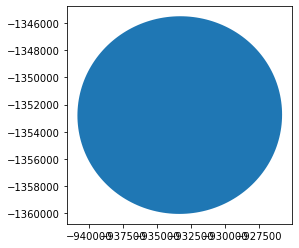

In [4]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


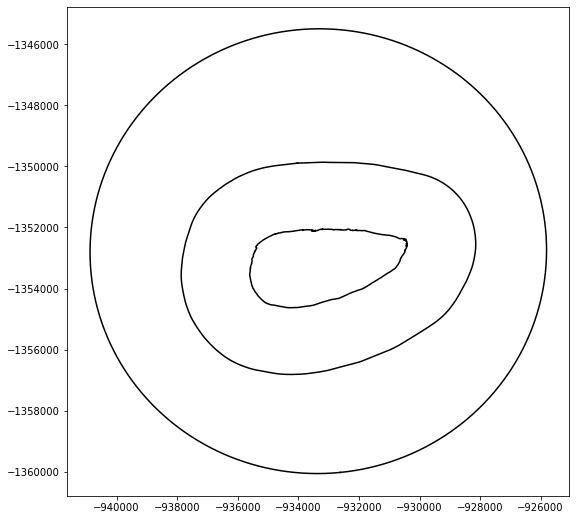

In [5]:
import shapefile as shpf

AMP_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
reef_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island.shp'
reefBuffer_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island_buffer20km.shp'

CI = shpf.Reader(AMP_path)
CI_I = shpf.Reader(reef_path)
CI_IB = shpf.Reader(reefBuffer_path)
plt.figure(figsize=(9,9))

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

for shape in CI_I.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
for shape in CI_IB.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

In [6]:
from shapely.geometry import shape, mapping
import fiona

AMP_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
reef_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island.shp'
##open the polygon
with fiona.open(AMP_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        x = next(iter(shapes))
        first_geometry = next(iter(shapes))['geometry']
        geom1 = geometry.Geometry(first_geometry, crs=crs)

with fiona.open(reef_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom2 = geometry.Geometry(first_geometry, crs=crs)

a = shape(geom1)
b = shape(geom2.buffer(2000)) # buffer 2 km
newGeom = a.difference(b) # erase b from a

newGeom1 = mapping(newGeom)

newGeom2 = geometry.Geometry(newGeom1, crs=crs)


**load chl_oc3 data for the AMP**

In [7]:
query = {'geopolygon': newGeom2,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

In [8]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['chl_oc3']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:18:05.004203 to finish


In [9]:
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    chl_oc3  (time, y, x) float32 0.34175664 0.3226104 ... -999.0 -999.0
Attributes:
    crs:      EPSG:3577

**create a mask for the area covered by the AMP polygon**

In [10]:
mask = rasterio.features.geometry_mask([newGeom2.to_crs(data.geobox.crs) for geoms in [newGeom2]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

In [11]:
data = mask_invalid_data(data)

In [12]:
# note the time dimension: 6214
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    chl_oc3  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [13]:
data1 = data.copy(deep=True)
x = data1.chl_oc3
# the chl values greater than 5.0 mg/m3 are likely over-estimated; these values are reset to 5.0 mg/m3
x = x.where((x < 5) | (np.isnan(x)),5)
data1['chl_oc3'] = x

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

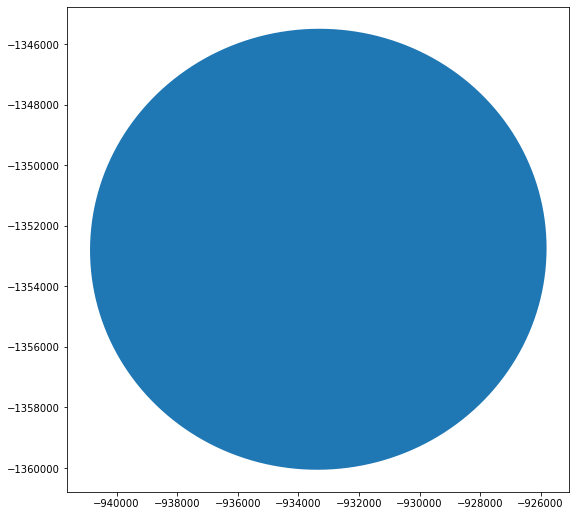

In [14]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot(figsize=(9,9))

plt.show()

<Figure size 576x576 with 0 Axes>

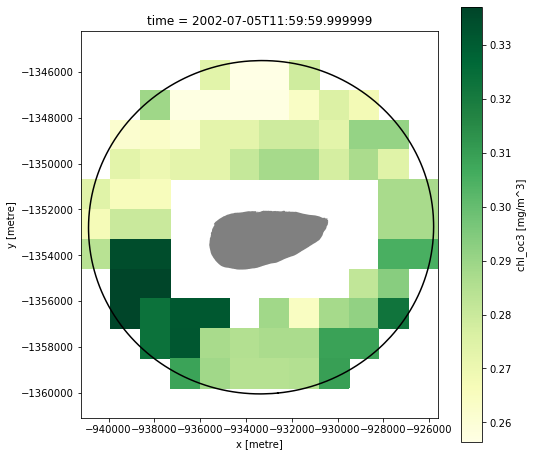

In [144]:
#plot polygon to check it looks ok

import shapefile as shpf
AMP_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
reef_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island.shp'
reefBuffer_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island_buffer20km.shp'

plt.figure(figsize=(8,8))

CI = shpf.Reader(AMP_path)
#CI_I = shpf.Reader(reef_path)
CI_IB = shpf.Reader(reefBuffer_path)

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(8,8),color='gray')

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

# for shape in CI_I.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x, y, 'k',color='red')
# for shape in CI_IB.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x, y, 'k')

data1.chl_oc3[1].plot(cmap='YlGn')


**the pad function for linear interpolation of missing data in a time series**

In [16]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


## conduct zonal statstists

**conduct zonal statistics for all chl_oc3 data (data), convert the results to a DataFrame**

**in doing so, we obtained the daily chl time-series of the AMP**

In [17]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
i = 0
propertiesList = []
dateList = []
while i < data1['chl_oc3'].time.size:
    date = str(data1['chl_oc3'].time[i].data)[:10]
    print(date)
    dateList.append(date)
    chl = data1.chl_oc3[i].data
    # conduct zonal statistics
    stats = zonal_stats(poly_path,chl,affine=data1.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    
    propertiesList.append(stats[0]['properties'])    
    
    i = i + 1
chlWDF = pd.DataFrame(propertiesList)
chlWDF['date']=dateList
chlWDF.set_index('date',inplace=True)

2002-07-04
2002-07-05
2002-07-06


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


2002-07-07
2002-07-08
2002-07-09
2002-07-10
2002-07-11
2002-07-12
2002-07-13
2002-07-14
2002-07-15
2002-07-16
2002-07-17
2002-07-18
2002-07-19
2002-07-20
2002-07-21
2002-07-22
2002-07-23
2002-07-24
2002-07-25
2002-07-26
2002-07-27
2002-07-28
2002-07-29
2002-08-07
2002-08-08
2002-08-09
2002-08-10
2002-08-11
2002-08-12
2002-08-13
2002-08-14
2002-08-15
2002-08-16
2002-08-17
2002-08-18
2002-08-19
2002-08-20
2002-08-21
2002-08-22
2002-08-23
2002-08-24
2002-08-25
2002-08-26
2002-08-27
2002-08-28
2002-08-29
2002-08-30
2002-08-31
2002-09-01
2002-09-02
2002-09-03
2002-09-04
2002-09-05
2002-09-06
2002-09-07
2002-09-08
2002-09-09
2002-09-10
2002-09-11
2002-09-12
2002-09-13
2002-09-14
2002-09-15
2002-09-16
2002-09-17
2002-09-18
2002-09-19
2002-09-20
2002-09-21
2002-09-22
2002-09-23
2002-09-24
2002-09-25
2002-09-26
2002-09-27
2002-09-28
2002-09-29
2002-09-30
2002-10-01
2002-10-02
2002-10-03
2002-10-04
2002-10-05
2002-10-06
2002-10-07
2002-10-08
2002-10-09
2002-10-10
2002-10-11
2002-10-12
2002-10-13

2004-08-02
2004-08-03
2004-08-04
2004-08-05
2004-08-06
2004-08-07
2004-08-08
2004-08-09
2004-08-10
2004-08-11
2004-08-12
2004-08-13
2004-08-14
2004-08-15
2004-08-16
2004-08-17
2004-08-18
2004-08-19
2004-08-20
2004-08-21
2004-08-22
2004-08-23
2004-08-24
2004-08-25
2004-08-26
2004-08-27
2004-08-28
2004-08-29
2004-08-30
2004-08-31
2004-09-01
2004-09-02
2004-09-03
2004-09-04
2004-09-05
2004-09-06
2004-09-07
2004-09-08
2004-09-09
2004-09-10
2004-09-11
2004-09-12
2004-09-13
2004-09-14
2004-09-15
2004-09-16
2004-09-17
2004-09-18
2004-09-19
2004-09-20
2004-09-21
2004-09-22
2004-09-23
2004-09-24
2004-09-25
2004-09-26
2004-09-27
2004-09-28
2004-09-29
2004-09-30
2004-10-01
2004-10-02
2004-10-03
2004-10-04
2004-10-05
2004-10-06
2004-10-07
2004-10-08
2004-10-09
2004-10-10
2004-10-11
2004-10-12
2004-10-13
2004-10-14
2004-10-15
2004-10-16
2004-10-17
2004-10-18
2004-10-19
2004-10-20
2004-10-21
2004-10-22
2004-10-23
2004-10-24
2004-10-25
2004-10-26
2004-10-27
2004-10-28
2004-10-29
2004-10-30
2004-10-31

2006-08-24
2006-08-25
2006-08-26
2006-08-27
2006-08-28
2006-08-29
2006-08-30
2006-08-31
2006-09-01
2006-09-02
2006-09-03
2006-09-04
2006-09-05
2006-09-06
2006-09-07
2006-09-08
2006-09-09
2006-09-10
2006-09-11
2006-09-12
2006-09-13
2006-09-14
2006-09-15
2006-09-16
2006-09-17
2006-09-18
2006-09-19
2006-09-20
2006-09-21
2006-09-22
2006-09-23
2006-09-24
2006-09-25
2006-09-26
2006-09-27
2006-09-28
2006-09-29
2006-09-30
2006-10-01
2006-10-02
2006-10-03
2006-10-04
2006-10-05
2006-10-06
2006-10-07
2006-10-08
2006-10-09
2006-10-10
2006-10-11
2006-10-12
2006-10-13
2006-10-14
2006-10-15
2006-10-16
2006-10-17
2006-10-18
2006-10-19
2006-10-20
2006-10-21
2006-10-22
2006-10-23
2006-10-24
2006-10-25
2006-10-26
2006-10-27
2006-10-28
2006-10-29
2006-10-30
2006-10-31
2006-11-01
2006-11-02
2006-11-03
2006-11-04
2006-11-05
2006-11-06
2006-11-07
2006-11-08
2006-11-09
2006-11-10
2006-11-11
2006-11-12
2006-11-13
2006-11-14
2006-11-15
2006-11-16
2006-11-17
2006-11-18
2006-11-19
2006-11-20
2006-11-21
2006-11-22

2008-09-13
2008-09-14
2008-09-15
2008-09-16
2008-09-17
2008-09-18
2008-09-19
2008-09-20
2008-09-21
2008-09-22
2008-09-23
2008-09-24
2008-09-25
2008-09-26
2008-09-27
2008-09-28
2008-09-29
2008-09-30
2008-10-01
2008-10-02
2008-10-03
2008-10-04
2008-10-05
2008-10-06
2008-10-07
2008-10-08
2008-10-09
2008-10-10
2008-10-11
2008-10-12
2008-10-13
2008-10-14
2008-10-15
2008-10-16
2008-10-17
2008-10-18
2008-10-19
2008-10-20
2008-10-21
2008-10-22
2008-10-23
2008-10-24
2008-10-25
2008-10-26
2008-10-27
2008-10-28
2008-10-29
2008-10-30
2008-10-31
2008-11-01
2008-11-02
2008-11-03
2008-11-04
2008-11-05
2008-11-06
2008-11-07
2008-11-08
2008-11-09
2008-11-10
2008-11-11
2008-11-12
2008-11-13
2008-11-14
2008-11-15
2008-11-16
2008-11-17
2008-11-18
2008-11-19
2008-11-20
2008-11-21
2008-11-22
2008-11-23
2008-11-24
2008-11-25
2008-11-26
2008-11-27
2008-11-28
2008-11-29
2008-11-30
2008-12-01
2008-12-02
2008-12-03
2008-12-04
2008-12-05
2008-12-06
2008-12-07
2008-12-08
2008-12-09
2008-12-10
2008-12-11
2008-12-12

2010-10-03
2010-10-04
2010-10-05
2010-10-06
2010-10-07
2010-10-08
2010-10-09
2010-10-10
2010-10-11
2010-10-12
2010-10-13
2010-10-14
2010-10-15
2010-10-16
2010-10-17
2010-10-18
2010-10-19
2010-10-20
2010-10-21
2010-10-22
2010-10-23
2010-10-24
2010-10-25
2010-10-26
2010-10-27
2010-10-28
2010-10-29
2010-10-30
2010-10-31
2010-11-01
2010-11-02
2010-11-03
2010-11-04
2010-11-05
2010-11-06
2010-11-07
2010-11-08
2010-11-09
2010-11-10
2010-11-11
2010-11-12
2010-11-13
2010-11-14
2010-11-15
2010-11-16
2010-11-17
2010-11-18
2010-11-19
2010-11-20
2010-11-21
2010-11-22
2010-11-23
2010-11-24
2010-11-25
2010-11-26
2010-11-27
2010-11-28
2010-11-29
2010-11-30
2010-12-01
2010-12-02
2010-12-03
2010-12-04
2010-12-05
2010-12-06
2010-12-07
2010-12-08
2010-12-09
2010-12-10
2010-12-11
2010-12-12
2010-12-13
2010-12-14
2010-12-15
2010-12-16
2010-12-17
2010-12-18
2010-12-19
2010-12-20
2010-12-21
2010-12-22
2010-12-23
2010-12-24
2010-12-25
2010-12-26
2010-12-27
2010-12-28
2010-12-29
2010-12-30
2010-12-31
2011-01-01

2012-10-22
2012-10-23
2012-10-24
2012-10-25
2012-10-26
2012-10-27
2012-10-28
2012-10-29
2012-10-30
2012-10-31
2012-11-01
2012-11-02
2012-11-03
2012-11-04
2012-11-05
2012-11-06
2012-11-07
2012-11-08
2012-11-09
2012-11-10
2012-11-11
2012-11-12
2012-11-13
2012-11-14
2012-11-15
2012-11-16
2012-11-17
2012-11-18
2012-11-19
2012-11-20
2012-11-21
2012-11-22
2012-11-23
2012-11-24
2012-11-25
2012-11-26
2012-11-27
2012-11-28
2012-11-29
2012-11-30
2012-12-01
2012-12-02
2012-12-03
2012-12-04
2012-12-05
2012-12-06
2012-12-07
2012-12-08
2012-12-09
2012-12-10
2012-12-11
2012-12-12
2012-12-13
2012-12-14
2012-12-15
2012-12-16
2012-12-17
2012-12-18
2012-12-19
2012-12-20
2012-12-21
2012-12-22
2012-12-23
2012-12-24
2012-12-25
2012-12-26
2012-12-27
2012-12-28
2012-12-29
2012-12-30
2012-12-31
2013-01-01
2013-01-02
2013-01-03
2013-01-04
2013-01-05
2013-01-06
2013-01-07
2013-01-08
2013-01-09
2013-01-10
2013-01-11
2013-01-12
2013-01-13
2013-01-14
2013-01-15
2013-01-16
2013-01-17
2013-01-18
2013-01-19
2013-01-20

2014-11-11
2014-11-12
2014-11-13
2014-11-14
2014-11-15
2014-11-16
2014-11-17
2014-11-18
2014-11-19
2014-11-20
2014-11-21
2014-11-22
2014-11-23
2014-11-24
2014-11-25
2014-11-26
2014-11-27
2014-11-28
2014-11-29
2014-11-30
2014-12-01
2014-12-02
2014-12-03
2014-12-04
2014-12-05
2014-12-06
2014-12-07
2014-12-08
2014-12-09
2014-12-10
2014-12-11
2014-12-12
2014-12-13
2014-12-14
2014-12-15
2014-12-16
2014-12-17
2014-12-18
2014-12-19
2014-12-20
2014-12-21
2014-12-22
2014-12-23
2014-12-24
2014-12-25
2014-12-26
2014-12-27
2014-12-28
2014-12-29
2014-12-30
2014-12-31
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09

2016-11-28
2016-11-29
2016-11-30
2016-12-01
2016-12-02
2016-12-03
2016-12-04
2016-12-05
2016-12-06
2016-12-07
2016-12-08
2016-12-09
2016-12-10
2016-12-11
2016-12-12
2016-12-13
2016-12-14
2016-12-15
2016-12-16
2016-12-17
2016-12-18
2016-12-19
2016-12-20
2016-12-21
2016-12-22
2016-12-23
2016-12-24
2016-12-25
2016-12-26
2016-12-27
2016-12-28
2016-12-29
2016-12-30
2016-12-31
2017-01-01
2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-07
2017-01-08
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-14
2017-01-15
2017-01-16
2017-01-17
2017-01-18
2017-01-19
2017-01-20
2017-01-21
2017-01-22
2017-01-23
2017-01-24
2017-01-25
2017-01-26
2017-01-27
2017-01-28
2017-01-29
2017-01-30
2017-01-31
2017-02-01
2017-02-02
2017-02-03
2017-02-04
2017-02-05
2017-02-06
2017-02-07
2017-02-08
2017-02-09
2017-02-10
2017-02-11
2017-02-12
2017-02-13
2017-02-14
2017-02-15
2017-02-16
2017-02-17
2017-02-18
2017-02-19
2017-02-20
2017-02-21
2017-02-22
2017-02-23
2017-02-24
2017-02-25
2017-02-26

2018-12-15
2018-12-16
2018-12-17
2018-12-18
2018-12-19
2018-12-20
2018-12-21
2018-12-22
2018-12-23
2018-12-24
2018-12-25
2018-12-26
2018-12-27
2018-12-28
2018-12-29
2018-12-30
2018-12-31
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15

**plot the daily mean and min chl time series for the AMP**

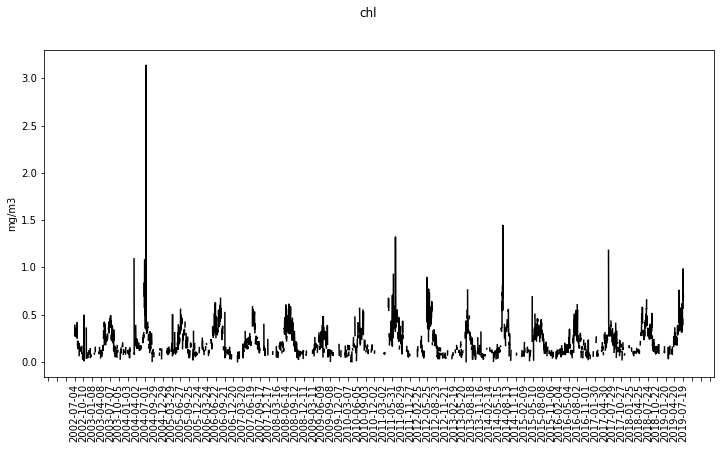

In [145]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')

ax.plot(chlWDF.index.values,chlWDF['mean'].values,color='black')
#ax.plot(chlWDF.index.values,chlWDF['min'].values,color='blue')
#ax.plot(chlWDF.index.values,chlWDF['max'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

**apply interpolation on the daily mean, min and max CHL time-series**

In [19]:
meanI = pad(chlWDF['mean'].values,maxPadLength=False)
minI = pad(chlWDF['min'].values,maxPadLength=False)
maxI = pad(chlWDF['max'].values,maxPadLength=False)
chlWDF['meanI'] = meanI
chlWDF['minI'] = minI
chlWDF['maxI'] = maxI

**plot the interploated daily time-series**

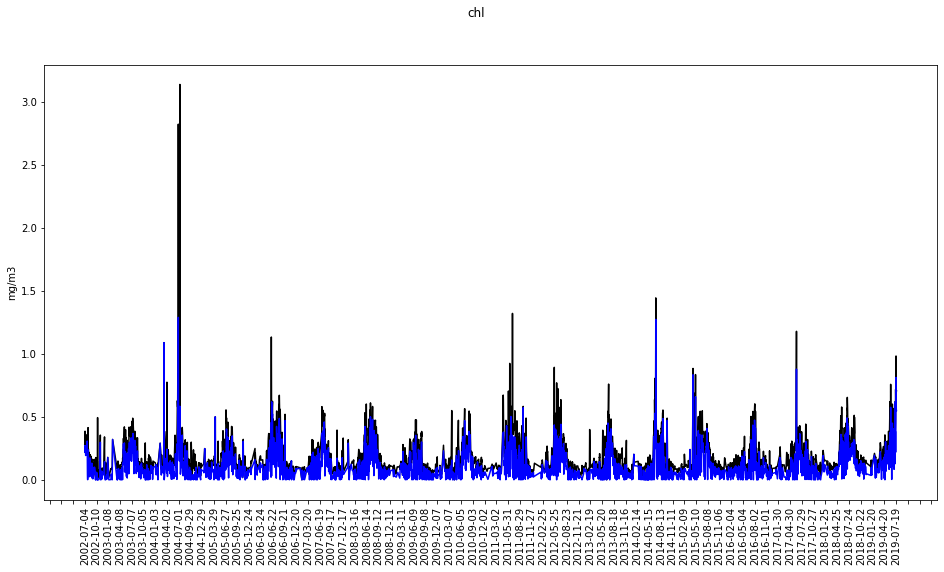

In [20]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(chlWDF.index.values,chlWDF['meanI'].values,color='black')
ax.plot(chlWDF.index.values,chlWDF['minI'].values,color='blue')
#ax.plot(chlWDF.index.values,chlWDF['maxI'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

**plot and fit a linear trend line to the daily time-series**

                            OLS Regression Results                            
Dep. Variable:                  meanI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.169
Date:                Fri, 27 Mar 2020   Prob (F-statistic):             0.0130
Time:                        10:38:51   Log-Likelihood:                 3288.0
No. Observations:                6214   AIC:                            -6572.
Df Residuals:                    6212   BIC:                            -6559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1774      0.004     49.024      0.0

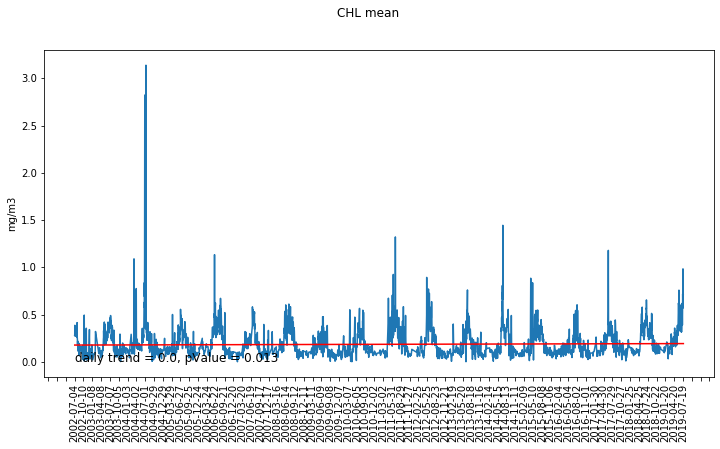

In [147]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,chlWDF['meanI'].size+1,1)
chlWDF['ind'] = ind

meanFit = sm.ols(formula='meanI ~ ind', data=chlWDF).fit()
print(meanFit.summary())

predict = meanFit.predict(chlWDF)
chlWDF['mean_fitted'] = predict

#rate = (chlWDF['mean_fitted'].max() - chlWDF['mean_fitted'].min()) / chlWDF['mean_fitted'].size
rate = round(meanFit.params[1],4)
pValue = round(meanFit.pvalues[1],4)

fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')

textX = chlWDF.index[0]
textY = chlWDF['meanI'].min()
plt.text(textX,textY,"daily trend = " + str(rate) + ", pValue = " + str(pValue),fontsize=12)
ax.plot(chlWDF.index.values,chlWDF['meanI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(chlWDF.ind, chlWDF.mean_fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL mean')

plt.show()

                            OLS Regression Results                            
Dep. Variable:                   minI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.709
Date:                Thu, 26 Mar 2020   Prob (F-statistic):             0.0542
Time:                        17:18:03   Log-Likelihood:                 5473.7
No. Observations:                6214   AIC:                        -1.094e+04
Df Residuals:                    6212   BIC:                        -1.093e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1003      0.003     39.408      0.0

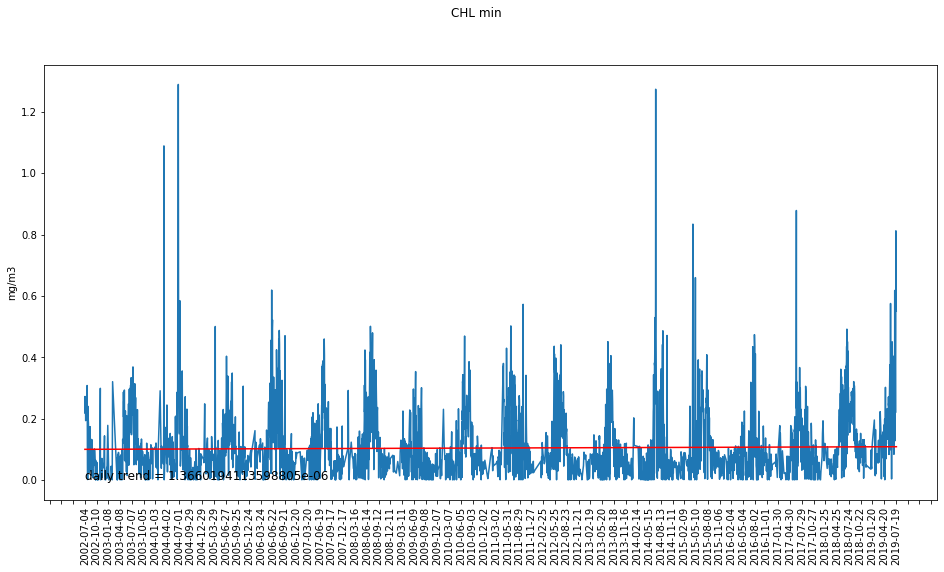

In [22]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm


minFit = sm.ols(formula='minI ~ ind', data=chlWDF).fit()
print(minFit.summary())

predict = minFit.predict(chlWDF)
chlWDF['min_fitted'] = predict

rate = minFit.params[1]

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = chlWDF.index[0]
textY = chlWDF['minI'].min()
plt.text(textX,textY,"daily trend = " + str(rate),fontsize=12)
ax.plot(chlWDF.index.values,chlWDF['minI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(chlWDF.ind, chlWDF.min_fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL min')

plt.show()

**conduct T test and F test on the linear trend (e.g., the ind param in this case)**

**add year, month, season and yearmonth column**

In [23]:
yearList = []
monthList = []
seasonList = []
yearmonthList = []
for date in chlWDF.index:
    year = date[:4]
    month = date[5:7]
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    yearList.append(year)
    monthList.append(month)
    seasonList.append(season)
    yearmonth = year+month
    yearmonthList.append(yearmonth)
chlWDF['year'] = yearList
chlWDF['month'] = monthList
chlWDF['season'] = seasonList
chlWDF['yearmonth'] = yearmonthList

In [24]:
chlWDF.head(10)

MPA_NAME     network        area  count       min       max  \
date                                                                            
2002-07-04  Cartier Island  North-west  172.374499     74  0.219028  0.437202   
2002-07-05  Cartier Island  North-west  172.374499     74  0.256408  0.337014   
2002-07-06  Cartier Island  North-west  172.374499     74  0.272551  0.444321   
2002-07-07  Cartier Island  North-west  172.374499      0       NaN       NaN   
2002-07-08  Cartier Island  North-west  172.374499     74  0.237713  0.430212   
2002-07-09  Cartier Island  North-west  172.374499      0       NaN       NaN   
2002-07-10  Cartier Island  North-west  172.374499     74  0.221449  0.345159   
2002-07-11  Cartier Island  North-west  172.374499     74  0.193791  0.644601   
2002-07-12  Cartier Island  North-west  172.374499     74  0.234910  0.349412   
2002-07-13  Cartier Island  North-west  172.374499     74  0.243048  0.384934   

                mean        sum       std    median  ...     meanI      minI  \
date                                                 ...                       
2002-07-04  0.282316  20.891404  0.036252  0.275236  ...  0.282316  0.219028   
2002-07-05  0.287571  21.280237  0.022430  0.284785  ...  0.287571  0.256408   
2002-07-06  0.386405  28.593986  0.039322  0.390818  ...  0.386405  0.272551   
2002-07-07       NaN        NaN       NaN       NaN  ...  0.367541  0.255132   
2002-07-08  0.348677  25.802093  0.048085  0.356008  ...  0.348677  0.237713   
2002-07-09       NaN        NaN       NaN       NaN  ...  0.309422  0.229581   
2002-07-10  0.270167  19.992370  0.032220  0.264350  ...  0.270167  0.221449   
2002-07-11  0.279946  20.716009  0.064434  0.273454  ...  0.279946  0.193791   
2002-07-12  0.286104  21.171732  0.032311  0.276715  ...  0.286104  0.234910   
2002-07-13  0.293076  21.687631  0.030963  0.290107  ...  0.293076  0.243048   

                maxI  ind  mean_fitted  min_fitted  year month  season  \
date                                                                     
2002-07-04  0.437202    1     0.177356    0.100292  2002    07  winter   
2002-07-05  0.337014    2     0.177359    0.100293  2002    07  winter   
2002-07-06  0.444321    3     0.177361    0.100295  2002    07  winter   
2002-07-07  0.437266    4     0.177364    0.100296  2002    07  winter   
2002-07-08  0.430212    5     0.177366    0.100298  2002    07  winter   
2002-07-09  0.387685    6     0.177369    0.100299  2002    07  winter   
2002-07-10  0.345159    7     0.177371    0.100300  2002    07  winter   
2002-07-11  0.644601    8     0.177374    0.100302  2002    07  winter   
2002-07-12  0.349412    9     0.177376    0.100303  2002    07  winter   
2002-07-13  0.384934   10     0.177379    0.100304  2002    07  winter   

           yearmonth  
date                  
2002-07-04    200207  
2002-07-05    200207  
2002-07-06    200207  
2002-07-07    200207  
2002-07-08    200207  
2002-07-09    200207  
2002-07-10    200207  
2002-07-11    200207  
2002-07-12    200207  
2002-07-13    200207  

[10 rows x 21 columns]

**group by year**

**the describe function generates a dataframe with the groupping results (time-series of annual mean/min/max)**

In [25]:
x = chlWDF['mean'].groupby(chlWDF['year'])
yearmeanchlWDF = x.describe()
x = chlWDF['min'].groupby(chlWDF['year'])
yearminchlWDF = x.describe()
x = chlWDF['max'].groupby(chlWDF['year'])
yearmaxchlWDF = x.describe()
x = chlWDF['std'].groupby(chlWDF['year'])
yearstdchlWDF = x.describe()

x = chlWDF['mean'].groupby(chlWDF['yearmonth'])
yearmonthmeanchlWDF = x.describe()

x = chlWDF['std'].groupby(chlWDF['yearmonth'])
yearmonthstdchlWDF = x.describe()

**year 2002 and 2019 are partial years and should not be included**

In [26]:
yearmeanchlWDF1 = yearmeanchlWDF.loc['2003':'2018']
yearminchlWDF1 = yearminchlWDF.loc['2003':'2018']
yearmaxchlWDF1 = yearmaxchlWDF.loc['2003':'2018']
yearstdchlWDF1 = yearstdchlWDF.loc['2003':'2018']

yearmonthmeanchlWDF1 = yearmonthmeanchlWDF.loc['200301':'201812']
yearmonthstdchlWDF1 = yearmonthstdchlWDF.loc['200301':'201812']

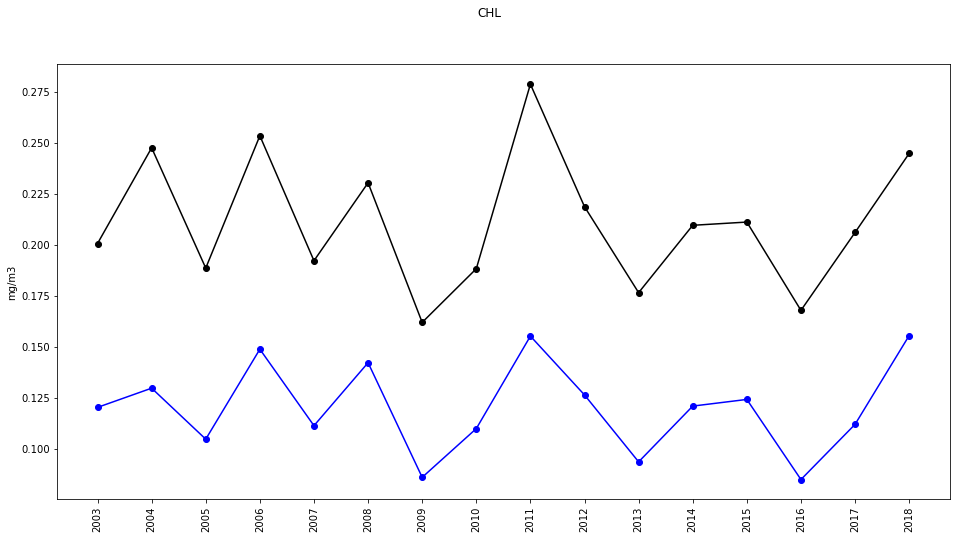

In [27]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o',color='black')
ax.plot(yearminchlWDF1.index.values,yearminchlWDF1['mean'].values,marker='o',color='blue')
#ax.plot(yearmaxchlWDF1.index.values,yearmaxchlWDF1['mean'].values,marker='o',color='red')

ax.set_ylabel('mg/m3')
fig.suptitle('CHL')

plt.show()

**plot the annual mean CHL time-series and the (temporal) standard deviation**

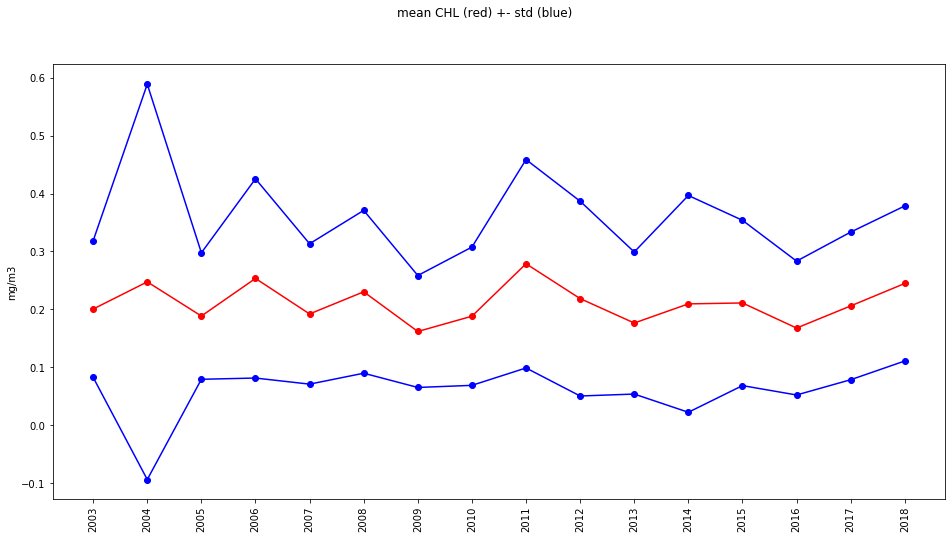

In [28]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o',color='red')
ax.plot(yearstdchlWDF1.index.values,yearmeanchlWDF1['mean'].values-yearmeanchlWDF1['std'],marker='o',color='blue')
ax.plot(yearstdchlWDF1.index.values,yearmeanchlWDF1['mean'].values+yearmeanchlWDF1['std'],marker='o',color='blue')

ax.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')

plt.show()

**plot daily CHL time-series and the annual mean CHL time-series**

In [29]:
chlWDF1 = chlWDF.loc['2003-01-01':'2018-12-31']

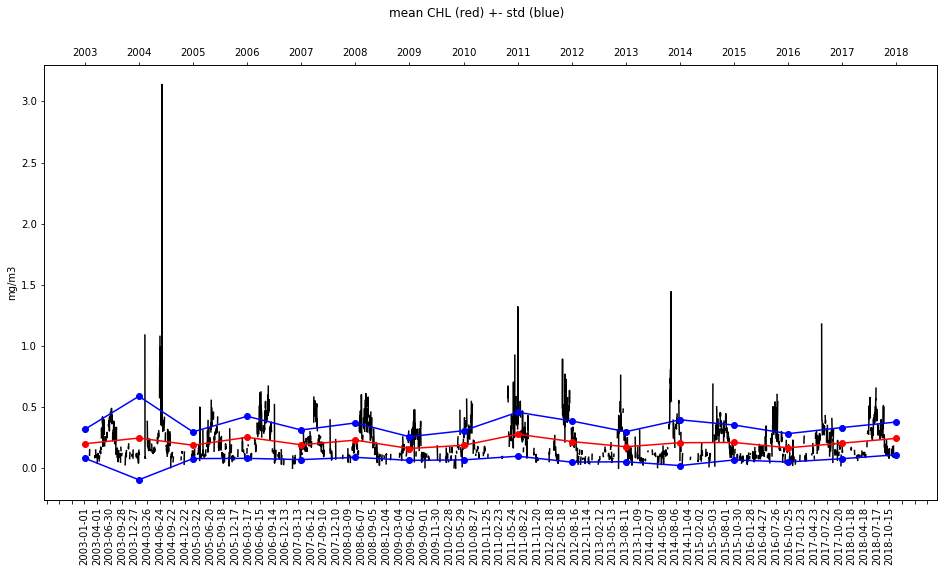

In [30]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax1.plot(chlWDF1.index.values,chlWDF1['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(90))

ax2 = ax1.twiny()
ax2.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o',color='red')
ax2.plot(yearstdchlWDF1.index.values,yearmeanchlWDF1['mean'].values-yearmeanchlWDF1['std'],marker='o',color='blue')
ax2.plot(yearstdchlWDF1.index.values,yearmeanchlWDF1['mean'].values+yearmeanchlWDF1['std'],marker='o',color='blue')

ax1.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')

plt.show()

**plot the daily SST time-series and monthly SST time-series**

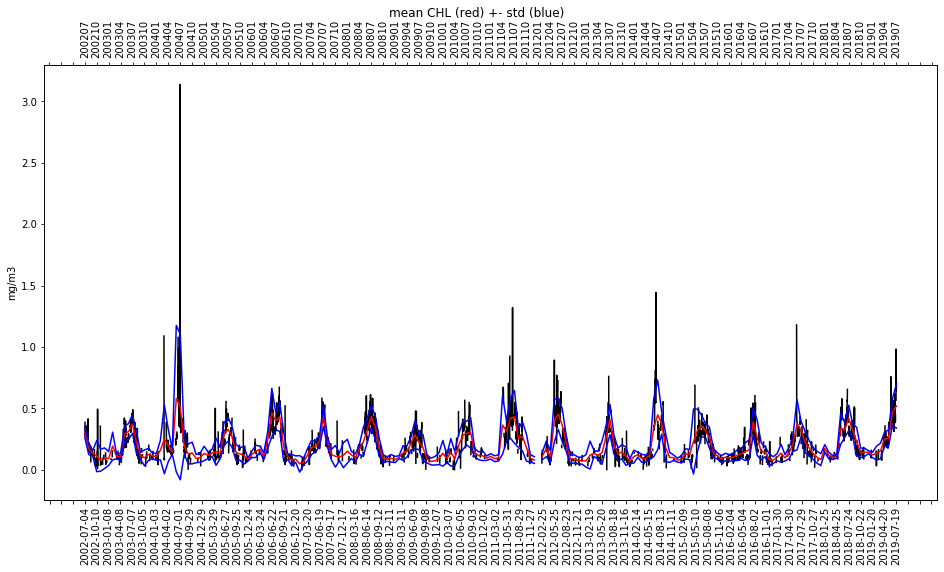

In [31]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(chlWDF.index.values,chlWDF['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(90))

ax2 = ax1.twiny()
ax2.plot(yearmonthmeanchlWDF.index.values,yearmonthmeanchlWDF['mean'].values,color='red')
ax2.plot(yearmonthstdchlWDF.index.values,yearmonthmeanchlWDF['mean'].values-yearmonthmeanchlWDF['std'],color='blue')
ax2.plot(yearmonthstdchlWDF.index.values,yearmonthmeanchlWDF['mean'].values+yearmonthmeanchlWDF['std'],color='blue')
#ax2.set_xticklabels(yearmonthmeanchlWDF.index.values,rotation="vertical")
plt.xticks(rotation='vertical')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))

#ax1.set_xticks(yearmeanchlWDF1.index.values)
ax1.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')



plt.show()

**plot monthly CHL time-series and annual CHL time-series**

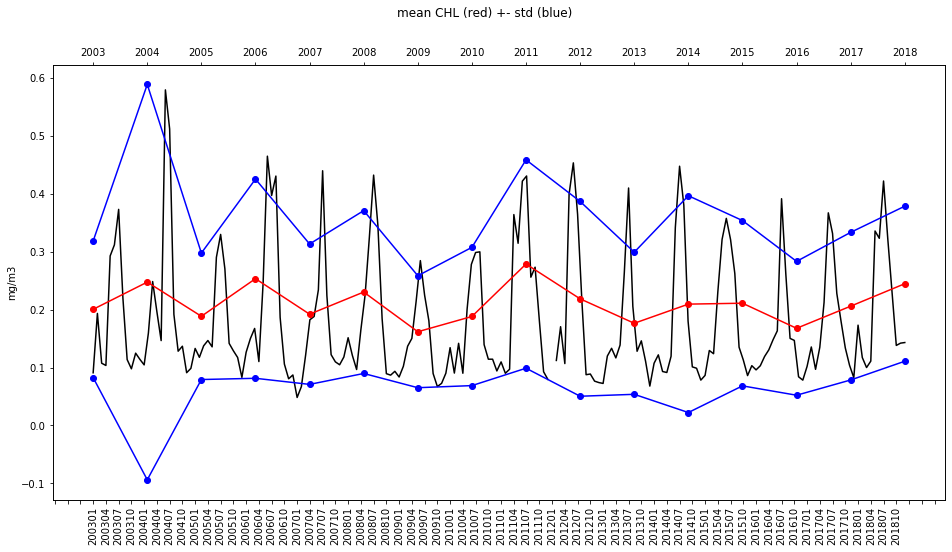

In [32]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(yearmonthmeanchlWDF1.index.values,yearmonthmeanchlWDF1['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax2 = ax1.twiny()
ax2.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o',color='red')
ax2.plot(yearstdchlWDF1.index.values,yearmeanchlWDF1['mean'].values-yearmeanchlWDF1['std'],marker='o',color='blue')
ax2.plot(yearstdchlWDF1.index.values,yearmeanchlWDF1['mean'].values+yearmeanchlWDF1['std'],marker='o',color='blue')

ax1.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')



plt.show()

**plot and fit the time-serie of annual means/mins**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.08847
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.770
Time:                        17:18:24   Log-Likelihood:                 32.463
No. Observations:                  16   AIC:                            -60.93
Df Residuals:                      14   BIC:                            -59.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2157      0.018     12.093      0.0

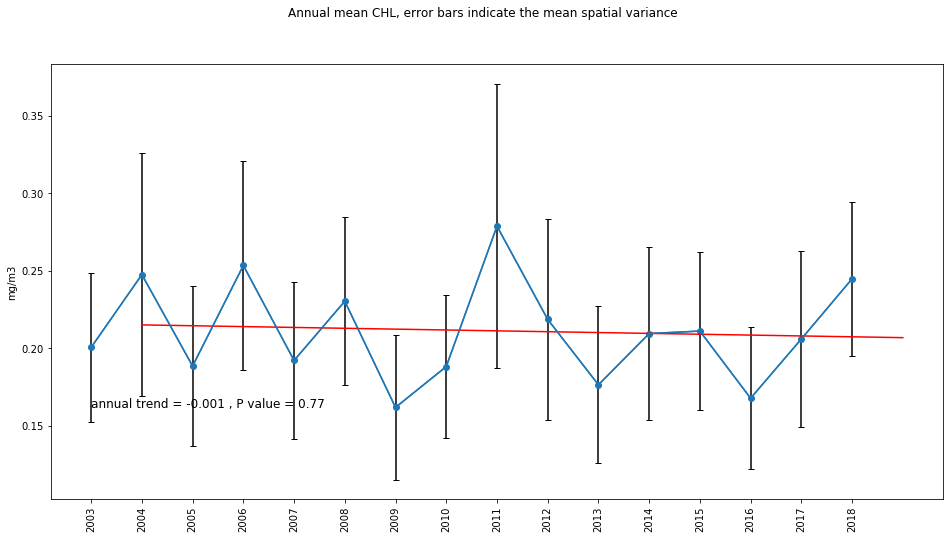

In [33]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanchlWDF1['mean'].size+1,1)
yearmeanchlWDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanchlWDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanchlWDF1)
yearmeanchlWDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanchlWDF1.index[0]
textY = yearmeanchlWDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o')

ax.errorbar(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,yerr=yearstdchlWDF1['mean'].values,ecolor="black",
           capsize=3.0)

ax.plot(yearmeanchlWDF1.ind, yearmeanchlWDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('Annual mean CHL, error bars indicate the mean spatial variance')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.08847
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.770
Time:                        17:18:24   Log-Likelihood:                 32.463
No. Observations:                  16   AIC:                            -60.93
Df Residuals:                      14   BIC:                            -59.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2157      0.018     12.093      0.0

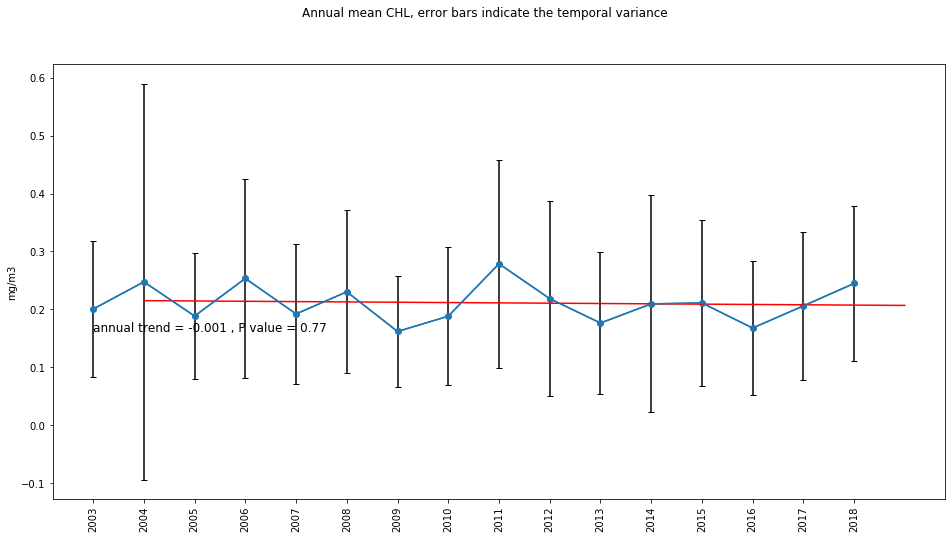

In [34]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanchlWDF1['mean'].size+1,1)
yearmeanchlWDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanchlWDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanchlWDF1)
yearmeanchlWDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanchlWDF1.index[0]
textY = yearmeanchlWDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o')

ax.errorbar(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,yerr=yearmeanchlWDF1['std'].values,ecolor="black",
           capsize=3.0)

ax.plot(yearmeanchlWDF1.ind, yearmeanchlWDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('Annual mean CHL, error bars indicate the temporal variance')

plt.show()

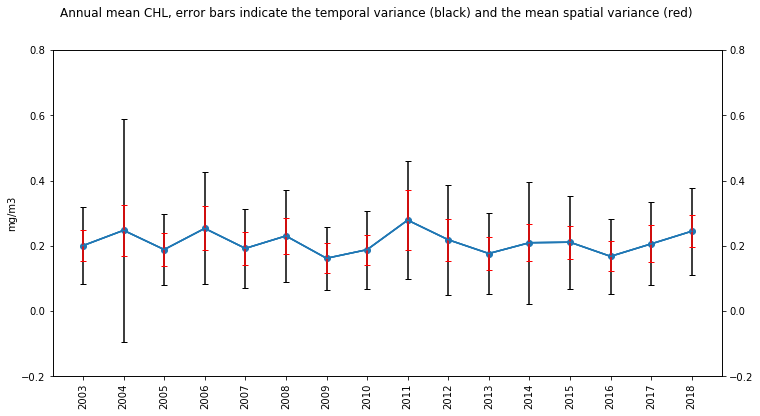

In [148]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')


ax1.plot(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,marker='o')
ax1.errorbar(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,yerr=yearmeanchlWDF1['std'].values,ecolor="black",
           capsize=3.0)

ax1.set_ylabel('mg/m3')
ax1.set_ylim(ymin=-0.2,ymax=0.8)
ax2 = ax1.twinx()
ax2.errorbar(yearmeanchlWDF1.index.values,yearmeanchlWDF1['mean'].values,yerr=yearstdchlWDF1['mean'].values,ecolor="red",
           capsize=3.0)
ax2.set_ylim(ymin=-0.2,ymax=0.8)
fig.suptitle('Annual mean CHL, error bars indicate the temporal variance (black) and the mean spatial variance (red)')

plt.show()

**same analysis based on the interpolated CHL time-series**

In [36]:
x = chlWDF['meanI'].groupby(chlWDF['year'])
yearmeanIchlWDF = x.describe()
x = chlWDF['minI'].groupby(chlWDF['year'])
yearminIchlWDF = x.describe()
x = chlWDF['maxI'].groupby(chlWDF['year'])
yearmaxIchlWDF = x.describe()


yearmeanIchlWDF1 = yearmeanIchlWDF.loc['2003':'2018']
yearminIchlWDF1 = yearminIchlWDF.loc['2003':'2018']
yearmaxIchlWDF1 = yearmaxIchlWDF.loc['2003':'2018']

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.1421
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.712
Time:                        17:18:25   Log-Likelihood:                 37.304
No. Observations:                  16   AIC:                            -70.61
Df Residuals:                      14   BIC:                            -69.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1877      0.013     14.242      0.0

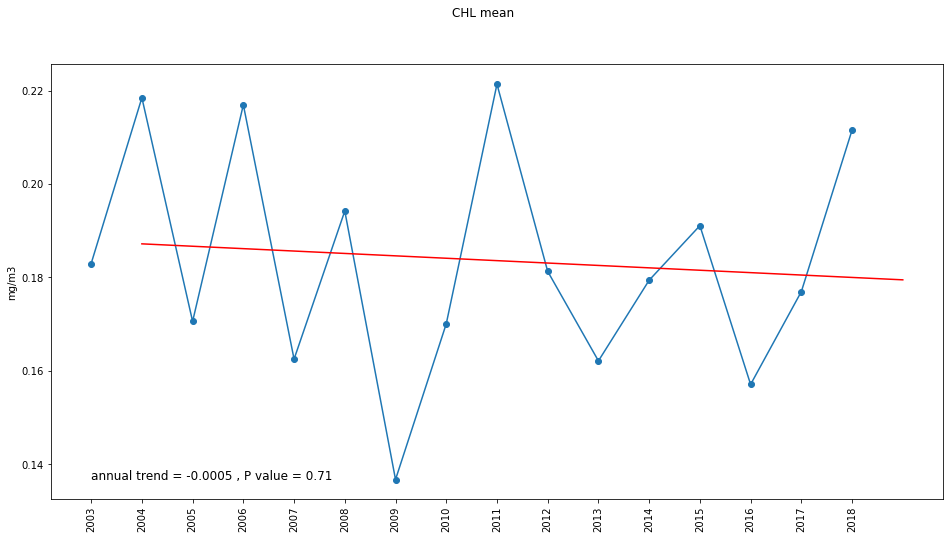

In [37]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanIchlWDF1['mean'].size+1,1)
yearmeanIchlWDF1['ind'] = ind

yearmeanIFit = sm.ols(formula='mean ~ ind', data=yearmeanIchlWDF1).fit()
print(yearmeanIFit.summary())

predict = yearmeanIFit.predict(yearmeanIchlWDF1)
yearmeanIchlWDF1['fitted'] = predict

rate = round(yearmeanIFit.params[1],4)
pValue = round(yearmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanIchlWDF1.index[0]
textY = yearmeanIchlWDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanIchlWDF1.index.values,yearmeanIchlWDF1['mean'].values,marker='o')


ax.plot(yearmeanIchlWDF1.ind, yearmeanIchlWDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL mean')

plt.show()

**variation of monthly means**

In [38]:
x = chlWDF['meanI'].groupby(chlWDF['month'])
monthmeanIchlWDF = x.describe()
x = chlWDF['mean'].groupby(chlWDF['month'])
monthmeanchlWDF = x.describe()
x = chlWDF['std'].groupby(chlWDF['month'])
monthstdchlWDF = x.describe()

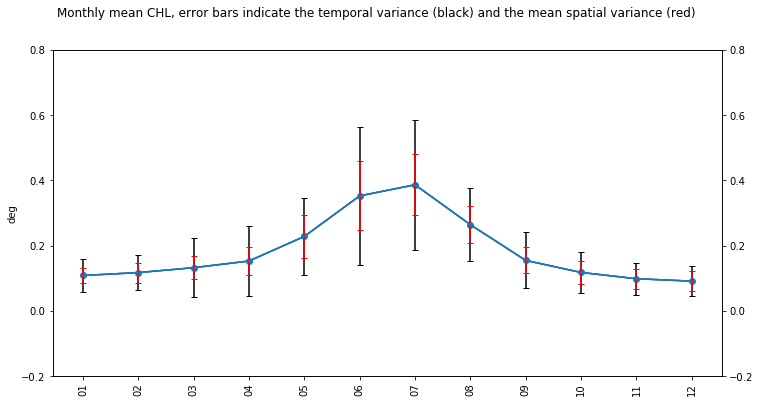

In [149]:
fig, ax1 = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')
ax1.plot(monthmeanchlWDF.index.values,monthmeanchlWDF['mean'].values,marker='o')
ax1.errorbar(monthmeanchlWDF.index.values,monthmeanchlWDF['mean'].values,yerr=monthmeanchlWDF['std'].values,ecolor="black",capsize=3.0)
ax1.set_ylabel('deg')
ax1.set_ylim(ymin=-0.2,ymax=0.8)
ax2 = ax1.twinx()
ax2.errorbar(monthmeanchlWDF.index.values,monthmeanchlWDF['mean'].values,yerr=monthstdchlWDF['mean'].values,ecolor="red",capsize=3.0)
ax2.set_ylim(ymin=-0.2,ymax=0.8)
fig.suptitle('Monthly mean CHL, error bars indicate the temporal variance (black) and the mean spatial variance (red)')

plt.show()

**annual time-series of each month**

In [40]:
# note how to deal with multiindex
meanIDF = chlWDF[['meanI','year','month']]
x = meanIDF.groupby(['year','month'])
yearmonthmeanIchlWDF = x.describe()

idx = pd.IndexSlice
JanmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['01']],:]
FebmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['02']],:]
MarmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['03']],:]
AprmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['04']],:]
MaymeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['05']],:]
JunmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['06']],:]
JulmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['07']],:]
AugmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['08']],:]
SepmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['09']],:]
OctmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['10']],:]
NovmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['11']],:]
DecmeanIchlWDF = yearmonthmeanIchlWDF.loc[idx[:,['12']],:]
JanmeanIchlWDF.reset_index(inplace=True)
JanmeanIchlWDF.set_index('year',inplace=True)
x = JanmeanIchlWDF.columns.droplevel(level=0)
JanmeanIchlWDF.columns=x
FebmeanIchlWDF.reset_index(inplace=True)
FebmeanIchlWDF.set_index('year',inplace=True)
x = FebmeanIchlWDF.columns.droplevel(level=0)
FebmeanIchlWDF.columns=x
MarmeanIchlWDF.reset_index(inplace=True)
MarmeanIchlWDF.set_index('year',inplace=True)
x = MarmeanIchlWDF.columns.droplevel(level=0)
MarmeanIchlWDF.columns=x
AprmeanIchlWDF.reset_index(inplace=True)
AprmeanIchlWDF.set_index('year',inplace=True)
x = AprmeanIchlWDF.columns.droplevel(level=0)
AprmeanIchlWDF.columns=x
MaymeanIchlWDF.reset_index(inplace=True)
MaymeanIchlWDF.set_index('year',inplace=True)
x = MaymeanIchlWDF.columns.droplevel(level=0)
MaymeanIchlWDF.columns=x
JunmeanIchlWDF.reset_index(inplace=True)
JunmeanIchlWDF.set_index('year',inplace=True)
x = JunmeanIchlWDF.columns.droplevel(level=0)
JunmeanIchlWDF.columns=x
JulmeanIchlWDF.reset_index(inplace=True)
JulmeanIchlWDF.set_index('year',inplace=True)
x = JulmeanIchlWDF.columns.droplevel(level=0)
JulmeanIchlWDF.columns=x
AugmeanIchlWDF.reset_index(inplace=True)
AugmeanIchlWDF.set_index('year',inplace=True)
x = AugmeanIchlWDF.columns.droplevel(level=0)
AugmeanIchlWDF.columns=x
SepmeanIchlWDF.reset_index(inplace=True)
SepmeanIchlWDF.set_index('year',inplace=True)
x = SepmeanIchlWDF.columns.droplevel(level=0)
SepmeanIchlWDF.columns=x
OctmeanIchlWDF.reset_index(inplace=True)
OctmeanIchlWDF.set_index('year',inplace=True)
x = OctmeanIchlWDF.columns.droplevel(level=0)
OctmeanIchlWDF.columns=x
NovmeanIchlWDF.reset_index(inplace=True)
NovmeanIchlWDF.set_index('year',inplace=True)
x = NovmeanIchlWDF.columns.droplevel(level=0)
NovmeanIchlWDF.columns=x
DecmeanIchlWDF.reset_index(inplace=True)
DecmeanIchlWDF.set_index('year',inplace=True)
x = DecmeanIchlWDF.columns.droplevel(level=0)
DecmeanIchlWDF.columns=x

**plot and fit annual time-series of each month**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.8346
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.375
Time:                        10:46:46   Log-Likelihood:                 22.677
No. Observations:                  18   AIC:                            -41.35
Df Residuals:                      16   BIC:                            -39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3544      0.036      9.899      0.0

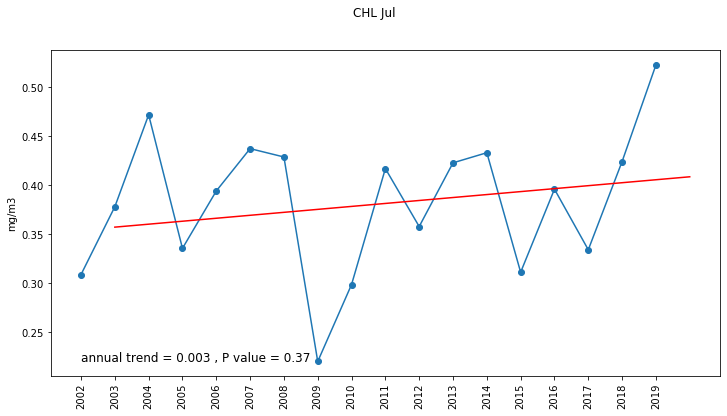

In [150]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JulmeanIchlWDF['mean'].size+1,1)
JulmeanIchlWDF['ind'] = ind

JulmeanIFit = sm.ols(formula='mean ~ ind', data=JulmeanIchlWDF).fit()
print(JulmeanIFit.summary())

predict = JulmeanIFit.predict(JulmeanIchlWDF)
JulmeanIchlWDF['fitted'] = predict

rate = round(JulmeanIFit.params[1],3)
pValue = round(JulmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')

textX = JulmeanIchlWDF.index[0]
textY = JulmeanIchlWDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JulmeanIchlWDF.index.values,JulmeanIchlWDF['mean'].values,marker='o')


ax.plot(JulmeanIchlWDF.ind, JulmeanIchlWDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Jul')

plt.show()

**annual time-series of each season**

In [42]:
meanIDF = chlWDF[['meanI','year','season']]
x = meanIDF.groupby(['year','season'])
yearseasonmeanIchlWDF = x.describe()

idx = pd.IndexSlice
SummermeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['summer']],:]
AutumnmeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['autumn']],:]
WintermeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['winter']],:]
SpringmeanIchlWDF = yearseasonmeanIchlWDF.loc[idx[:,['spring']],:]

SummermeanIchlWDF.reset_index(inplace=True)
SummermeanIchlWDF.set_index('year',inplace=True)
x = SummermeanIchlWDF.columns.droplevel(level=0)
SummermeanIchlWDF.columns=x
AutumnmeanIchlWDF.reset_index(inplace=True)
AutumnmeanIchlWDF.set_index('year',inplace=True)
x = AutumnmeanIchlWDF.columns.droplevel(level=0)
AutumnmeanIchlWDF.columns=x
WintermeanIchlWDF.reset_index(inplace=True)
WintermeanIchlWDF.set_index('year',inplace=True)
x = WintermeanIchlWDF.columns.droplevel(level=0)
WintermeanIchlWDF.columns=x
SpringmeanIchlWDF.reset_index(inplace=True)
SpringmeanIchlWDF.set_index('year',inplace=True)
x = SpringmeanIchlWDF.columns.droplevel(level=0)
SpringmeanIchlWDF.columns=x

In [43]:
SummermeanIchlWDF1 = SummermeanIchlWDF.loc['2003':'2018']

WintermeanIchlWDF1 = WintermeanIchlWDF.loc['2003':'2018']

**plot and fit annual time-series of the seasonal means**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.481
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.136
Time:                        10:50:23   Log-Likelihood:                 38.317
No. Observations:                  17   AIC:                            -72.63
Df Residuals:                      15   BIC:                            -70.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1034      0.014      7.537      0.0

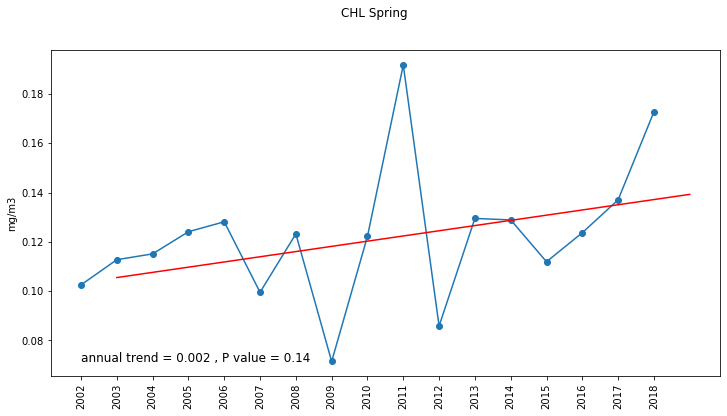

In [152]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SpringmeanIchlWDF['mean'].size+1,1)
SpringmeanIchlWDF['ind'] = ind

SpringmeanIFit = sm.ols(formula='mean ~ ind', data=SpringmeanIchlWDF).fit()
print(SpringmeanIFit.summary())

predict = SpringmeanIFit.predict(SpringmeanIchlWDF)
SpringmeanIchlWDF['fitted'] = predict

rate = round(SpringmeanIFit.params[1],3)
pValue = round(SpringmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')

textX = SpringmeanIchlWDF.index[0]
textY = SpringmeanIchlWDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SpringmeanIchlWDF.index.values,SpringmeanIchlWDF['mean'].values,marker='o')


ax.plot(SpringmeanIchlWDF.ind, SpringmeanIchlWDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Spring')

plt.show()

**annual trend on the number of high-productivity days each year**

**A high-productivity day is defined as a day with a mean CHL value greater than the 95% percentile of the whole time-series (all days in all years)**

In [45]:
productivedaysDF = pd.DataFrame()
productivedaysList = []
yearList = chlWDF.year.unique() # get unique values in a column
p95 = chlWDF['meanI'].quantile(0.95) # get 95% percentile of the entire time-series
print(p95)
for year in yearList:    
    tempDF = chlWDF[chlWDF['year'] == year]
    
    productivedays = (tempDF['meanI'] > p95).sum()
   
    productivedaysList.append(productivedays)
productivedaysDF['year'] = yearList
productivedaysDF['productivedays'] = productivedaysList
productivedaysDF.set_index('year',inplace=True)

0.44447392002898745


In [46]:
productivedaysDF1 = productivedaysDF.loc['2003':'2018']

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:         productivedays   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.08040
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.781
Time:                        10:51:42   Log-Likelihood:                -58.078
No. Observations:                  16   AIC:                             120.2
Df Residuals:                      14   BIC:                             121.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6500      5.115      3.646      0.0

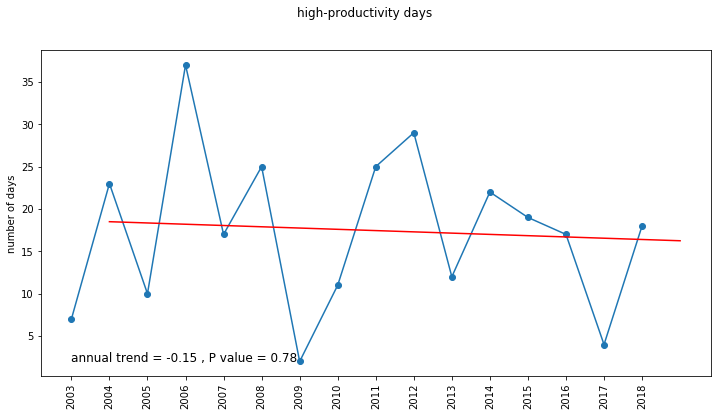

In [153]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,productivedaysDF1.index.size+1,1)
productivedaysDF1['ind'] = ind

productivedaysIFit = sm.ols(formula='productivedays ~ ind', data=productivedaysDF1).fit()
print(productivedaysIFit.summary())

predict = productivedaysIFit.predict(productivedaysDF1)
productivedaysDF1['fitted'] = predict

rate = round(productivedaysIFit.params[1],3)
pValue = round(productivedaysIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')

textX = productivedaysDF1.index[0]
textY = productivedaysDF1['productivedays'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(productivedaysDF1.index.values,productivedaysDF1['productivedays'].values,marker='o')


ax.plot(productivedaysDF1.ind, productivedaysDF1.fitted, 'r')
ax.set_ylabel('number of days')
fig.suptitle('high-productivity days')

plt.show()

##### **chlDF contains all chl_oc3 data loaded: 156 (12 x 13) locations (as columns) with 6214 daily time-series (as rows)**

**latlonDF contains the X, Y coordinates of the locations**

In [48]:
chlDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data1.y.size:
    while lonIndex < data1.x.size:
        lat = data1.chl_oc3[:,latIndex,lonIndex].y.values
        lon = data1.chl_oc3[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(str(id))
        chlData = data1.chl_oc3[:,latIndex,lonIndex].values
        chlDF[str(id)] = chlData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data1.time.size:
    date = str(data1.time[i].data)[:4] + str(data1.time[i].data)[5:7] + str(data1.time[i].data)[8:10]
    dateList.append(date)
    i += 1
chlDF['date'] = dateList
chlDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

**add year column**

In [49]:
yearList = []
for date in chlDF.index:
    year = date[:4]
    yearList.append(year)
chlDF['year'] = yearList

In [50]:
chlDF.tail(10)

1   2   3   4   5   6   7   8   9  10  ...  148  149  150  151  \
date                                              ...                       
20190713 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190714 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190715 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190716 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190717 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190718 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190719 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190720 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190721 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20190722 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   

          152  153  154  155  156  year  
date                                     
20190713  NaN  NaN  NaN  NaN  NaN  2019  
20190714  NaN  NaN  NaN  NaN  NaN  2019  
20190715  NaN  NaN  NaN  NaN  NaN  2019  
20190716  NaN  NaN  NaN  NaN  NaN  2019  
20190717  NaN  NaN  NaN  NaN  NaN  2019  
20190718  NaN  NaN  NaN  NaN  NaN  2019  
20190719  NaN  NaN  NaN  NaN  NaN  2019  
20190720  NaN  NaN  NaN  NaN  NaN  2019  
20190721  NaN  NaN  NaN  NaN  NaN  2019  
20190722  NaN  NaN  NaN  NaN  NaN  2019  

[10 rows x 157 columns]

**The yearCHLDF contains time-series of annual mean CHL values for pixels that have at least some valid data**

In [51]:
yearCHLDF = pd.DataFrame()
for col in chlDF.columns:
    print(col)
    if col.isdigit():
        
        nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if nuData > 0:            
            x = chlDF[col].groupby(chlDF['year']) # groupby year
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            yearCHLDF[col] = xDF['mean'] # only interest in the mean statistic

        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
year


In [52]:
yearCHLDF

17        18        19        20        27        28        29  \
year                                                                         
2002  0.171153  0.190303  0.187808  0.187800  0.183067  0.186128  0.191023   
2003  0.208515  0.214367  0.216218  0.214409  0.204974  0.201844  0.212122   
2004  0.225289  0.227236  0.220717  0.263312  0.226134  0.268026  0.224019   
2005  0.194390  0.201756  0.205436  0.215948  0.194089  0.186219  0.203398   
2006  0.279976  0.271540  0.273046  0.276329  0.250070  0.264186  0.267505   
2007  0.203018  0.205043  0.205167  0.207487  0.198524  0.208381  0.216074   
2008  0.255280  0.252980  0.253688  0.248107  0.250739  0.241005  0.261615   
2009  0.169476  0.176943  0.173385  0.177582  0.168556  0.166748  0.172917   
2010  0.198734  0.196680  0.199642  0.200558  0.190008  0.200486  0.192488   
2011  0.266876  0.276746  0.275527  0.287043  0.289899  0.292529  0.274975   
2012  0.231199  0.229848  0.229976  0.222131  0.237069  0.233194  0.230740   
2013  0.196964  0.189356  0.186967  0.190206  0.197732  0.188228  0.202182   
2014  0.226395  0.217196  0.220951  0.222286  0.244565  0.222562  0.257990   
2015  0.224927  0.226220  0.230081  0.252561  0.225855  0.218247  0.227939   
2016  0.186771  0.192141  0.182202  0.189569  0.178627  0.183357  0.183045   
2017  0.210150  0.212607  0.211772  0.205762  0.210018  0.208680  0.213819   
2018  0.255074  0.261400  0.251284  0.245831  0.260725  0.247449  0.253584   
2019  0.338962  0.343785  0.336690  0.339913  0.339339  0.328947  0.331330   

            30        31        32  ...       127       128       129  \
year                                ...                                 
2002  0.201984  0.187414  0.186748  ...  0.167708  0.168199  0.168064   
2003  0.211728  0.214220  0.219820  ...  0.192402  0.189255  0.185186   
2004  0.220552  0.217886  0.255888  ...  0.243168  0.237667  0.203219   
2005  0.201412  0.205703  0.199791  ...  0.191798  0.185624  0.186996   
2006  0.275037  0.274342  0.276923  ...  0.249431  0.258194  0.259134   
2007  0.217754  0.214139  0.214061  ...  0.194871  0.198140  0.198296   
2008  0.255411  0.256185  0.246927  ...  0.232134  0.231786  0.232384   
2009  0.172889  0.168485  0.173610  ...  0.175033  0.174315  0.170937   
2010  0.199337  0.203579  0.199795  ...  0.195764  0.200010  0.193491   
2011  0.273784  0.267778  0.271694  ...  0.288235  0.287389  0.270260   
2012  0.228087  0.224690  0.222856  ...  0.220697  0.215842  0.225393   
2013  0.206954  0.191252  0.202629  ...  0.180478  0.175108  0.175855   
2014  0.221834  0.226995  0.221389  ...  0.197882  0.202036  0.193730   
2015  0.225853  0.230361  0.239463  ...  0.206835  0.202844  0.205524   
2016  0.183278  0.185032  0.183795  ...  0.163844  0.165248  0.163453   
2017  0.220473  0.223998  0.210717  ...  0.197009  0.199466  0.201052   
2018  0.257550  0.252906  0.249515  ...  0.260925  0.249317  0.251897   
2019  0.349674  0.352365  0.345116  ...  0.319664  0.325614  0.329927   

           130       136       137       138       139       140       141  
year                                                                        
2002  0.182356  0.158087  0.155058  0.155880  0.156768  0.156063  0.166442  
2003  0.186132  0.190276  0.189820  0.187077  0.186671  0.185581  0.184588  
2004  0.202908  0.198088  0.197528  0.205960  0.214775  0.211166  0.188602  
2005  0.198015  0.171013  0.178821  0.180278  0.179960  0.180528  0.182673  
2006  0.259958  0.241443  0.254589  0.235677  0.246531  0.263545  0.266333  
2007  0.197558  0.184828  0.181429  0.185991  0.190527  0.191789  0.186291  
2008  0.235576  0.234944  0.228667  0.230528  0.223659  0.229327  0.229196  
2009  0.180501  0.157042  0.160486  0.167121  0.176718  0.168780  0.167748  
2010  0.195838  0.175689  0.180955  0.188377  0.190576  0.192563  0.195420  
2011  0.274169  0.289091  0.272341  0.287530  0.282902  0.281523  0.276221  
2012  0.227845  0.195158  0.201859  0.210495  0.245148  0.229580  

**years 2002 and 2019 are partial years and should be excluded for time-series analyses**

In [53]:
yearCHLDF1 = yearCHLDF.loc['2003':'2018']

**The yearRateDF contains, for each valid pixel, the fitted CHL annual trend rate, the number of days with data and the observation frequency within the time-series of the annual mean. A low observation frequency indicates high uncertainty of the fitted trend.**

In [54]:
import statsmodels.formula.api as sm
ind = np.arange(1,yearCHLDF1.index.size+1,1)
yearCHLDF1['ind'] = ind
yearRateDF = pd.DataFrame()
idList = []
rateList = []
pValueList = []
for col in yearCHLDF1.columns:
    print(col)
    if col.isdigit():
        idList.append(col)
        # note the Q() function for the proper handling of the number as a column name
        formula = 'Q("' + col + '")' + ' ~ ind'
        
        fit = sm.ols(formula=formula, data=yearCHLDF1).fit()

        predict = fit.predict(yearCHLDF1)
        yearCHLDF1['fitted'] = predict
        rate = round(fit.params[1],3)
        pValue = round(fit.pvalues[1],2)
        
        rateList.append(rate)
        pValueList.append(pValue)
yearRateDF['id'] = idList
yearRateDF['rate'] = rateList
yearRateDF['pValue'] = pValueList

countList = []
freqList = []
for col in chlDF.columns:
    if col.isdigit():        
        x = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if x > 0:            
            f = x/chlDF.index.size
            countList.append(x)
            freqList.append(f)
yearRateDF['count'] = countList
yearRateDF['frequency'] = freqList
yearRateDF.set_index("id",inplace=True)

17
18
19
20
27


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
71
72
73
74
75
83
84
85
86
87
95
96
98
99
106
107
110
111
112
113
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
ind


**add the x and y columns to the yearRateDF**

In [55]:
xList = []
yList = []
for id in yearRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearRateDF['x'] = xList
yearRateDF['y'] = yList

In [56]:
yearRateDF

rate  pValue  count  frequency       x        y
id                                                   
17   0.000    0.97   2165   0.348407 -935350 -1346150
18   0.000    0.99   2171   0.349372 -934050 -1346150
19  -0.000    0.86   2172   0.349533 -932750 -1346150
20  -0.001    0.55   2186   0.351786 -931450 -1346150
27   0.001    0.64   2152   0.346315 -937950 -1347450
..     ...     ...    ...        ...     ...      ...
137  0.000    0.92   2162   0.347924 -935350 -1359150
138  0.001    0.65   2148   0.345671 -934050 -1359150
139  0.000    0.95   2154   0.346637 -932750 -1359150
140 -0.000    0.93   2164   0.348246 -931450 -1359150
141 -0.000    0.98   2157   0.347119 -930150 -1359150

[74 rows x 6 columns]

**plot the annual trends for the pixels; the low observation frequency could indicate high uncertainty**

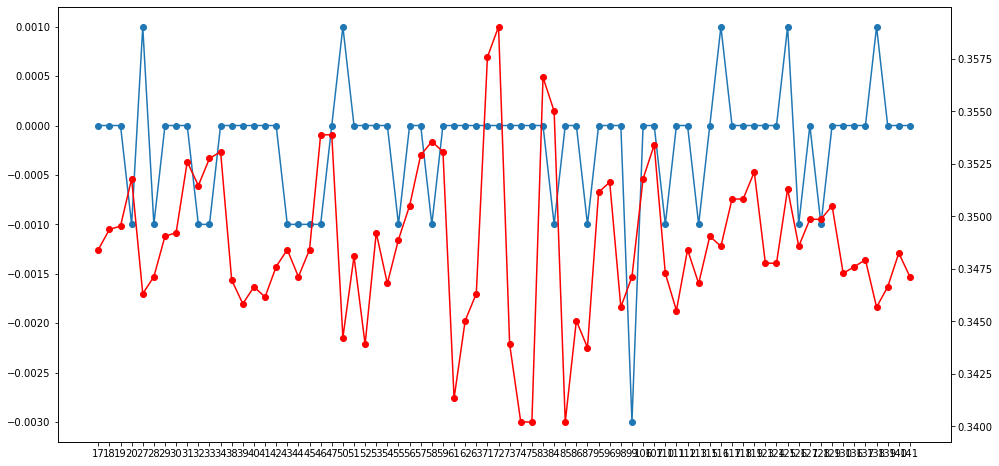

In [57]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(yearRateDF.index,yearRateDF['rate'],marker='o')
ax2.plot(yearRateDF.index,yearRateDF['frequency'],color='red',marker='o')

**convert the yearRateDF to an xarray dataset**

In [58]:
import xarray as xr
yearRateDF1 = yearRateDF.copy()
yearRateDF1.set_index(['y','x'],inplace=True)
yearRateData = xr.Dataset.from_dataframe(yearRateDF1)
yearRateData.attrs['crs']='EPSG:3577'

In [59]:
yearRateData

<xarray.Dataset>
Dimensions:    (x: 12, y: 11)
Coordinates:
  * y          (y) int64 -1359150 -1357850 -1356550 ... -1347450 -1346150
  * x          (x) int64 -940550 -939250 -937950 ... -928850 -927550 -926250
Data variables:
    rate       (y, x) float64 nan nan nan -0.0 0.0 ... -0.001 nan nan nan nan
    pValue     (y, x) float64 nan nan nan 0.96 0.92 ... 0.55 nan nan nan nan
    count      (y, x) float64 nan nan nan 2.16e+03 2.162e+03 ... nan nan nan nan
    frequency  (y, x) float64 nan nan nan 0.3476 0.3479 ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

**display the spatial distribution of the annual trend rates; the black dots indicate that the pixels have statitically significant warming rates at 80% confidence level**

<Figure size 864x576 with 0 Axes>

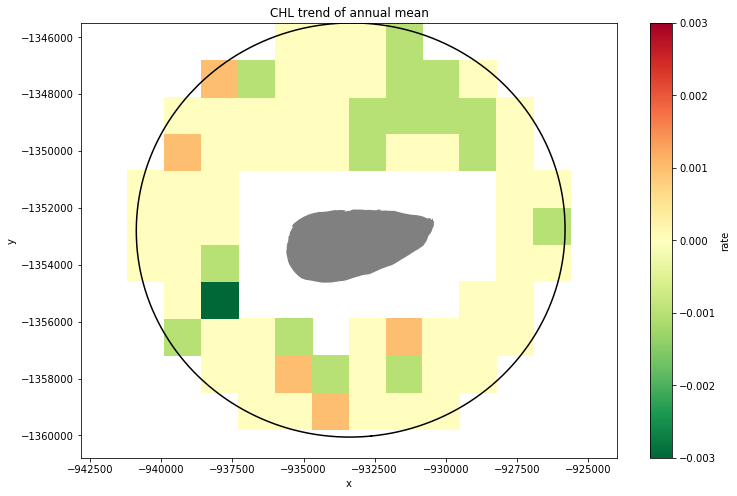

In [155]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
reef_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island_island.shp'
LH = shpf.Reader(poly_path)
minV = yearRateData['rate'].min()
maxV = yearRateData['rate'].max()

if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)
    
plt.figure(figsize=(12,8))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(12,8),color='gray')

yearRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL trend of annual mean')
plt.axis('equal')
# only highlight data points where pValue <= 0.20, representing significance level >= 80%
tempDF = yearRateDF[yearRateDF['pValue'] <= 0.20]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


**export the xarray dataset to a netcdf file**

In [61]:
yearRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearRateData_CHL.nc')

**plot the data, save it as an image, display the image**

<Figure size 1008x720 with 0 Axes>

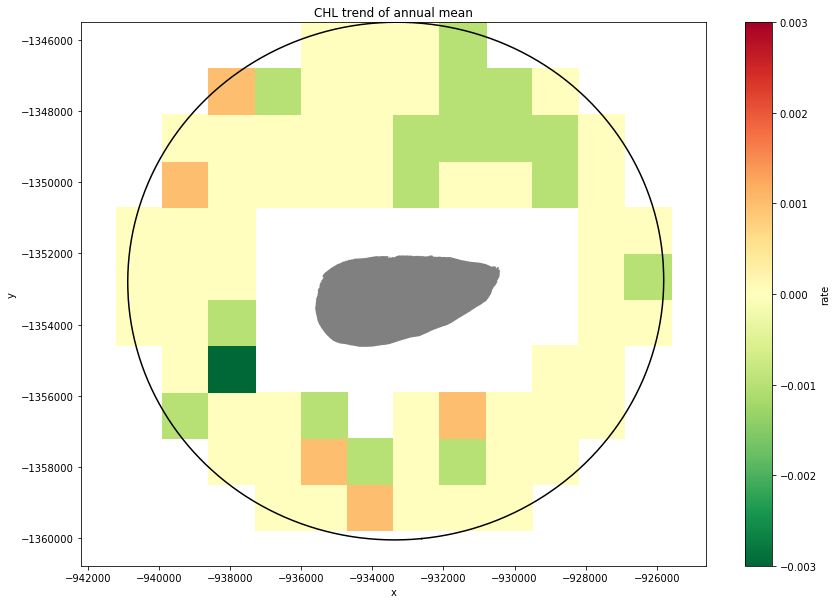

In [62]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

minV = yearRateData['rate'].min()
maxV = yearRateData['rate'].max()

if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)
    
plt.figure(figsize=(14,10))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(14,10),color='gray')

yearRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL trend of annual mean')
plt.axis('equal')
# only highlight data points where pValue <= 0.20, representing significance level >= 80%
tempDF = yearRateDF[yearRateDF['pValue'] <= 0.20]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

figName = "rateTest_CHL.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**The overallDF contains the long-term mean (std) CHL values for each valid pixels**

In [63]:
overallDF = pd.DataFrame()
meanList = []
stdList = []
countList = []
freqList = []
idList = []
for col in chlDF.columns:
    if col.isdigit():        
        x = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if x > 0:        
            chlMean = chlDF[col].mean()
            chlStd = chlDF[col].std()
            f = x/chlDF.index.size
            meanList.append(chlMean)
            stdList.append(chlStd)
            countList.append(x)
            freqList.append(f)
            idList.append(col)
overallDF['id'] = idList
overallDF['mean'] = meanList
overallDF['std'] = stdList
overallDF['count'] = countList
overallDF['frequency'] = freqList
overallDF.set_index('id', inplace=True)

xList = []
yList = []
for id in overallDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
overallDF['x'] = xList
overallDF['y'] = yList

In [64]:
overallDF

mean       std  count  frequency       x        y
id                                                        
17   0.222927  0.148286   2165   0.348407 -935350 -1346150
18   0.224680  0.149744   2171   0.349372 -934050 -1346150
19   0.223613  0.146756   2172   0.349533 -932750 -1346150
20   0.228526  0.171122   2186   0.351786 -931450 -1346150
27   0.222678  0.171154   2152   0.346315 -937950 -1347450
..        ...       ...    ...        ...     ...      ...
137  0.202423  0.153689   2162   0.347924 -935350 -1359150
138  0.206664  0.161318   2148   0.345671 -934050 -1359150
139  0.207966  0.192286   2154   0.346637 -932750 -1359150
140  0.207193  0.175549   2164   0.348246 -931450 -1359150
141  0.203516  0.150946   2157   0.347119 -930150 -1359150

[74 rows x 6 columns]

**convert the dataframe to an xarray daaset**

In [65]:
import xarray as xr
overallDF1 = overallDF.copy()
overallDF1.set_index(['y','x'],inplace=True)
overallData = xr.Dataset.from_dataframe(overallDF1)
overallData.attrs['crs']='EPSG:3577'

In [66]:
overallData

<xarray.Dataset>
Dimensions:    (x: 12, y: 11)
Coordinates:
  * y          (y) int64 -1359150 -1357850 -1356550 ... -1347450 -1346150
  * x          (x) int64 -940550 -939250 -937950 ... -928850 -927550 -926250
Data variables:
    mean       (y, x) float64 nan nan nan 0.1999 0.2024 ... nan nan nan nan
    std        (y, x) float64 nan nan nan 0.1472 0.1537 ... nan nan nan nan
    count      (y, x) float64 nan nan nan 2.16e+03 2.162e+03 ... nan nan nan nan
    frequency  (y, x) float64 nan nan nan 0.3476 0.3479 ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

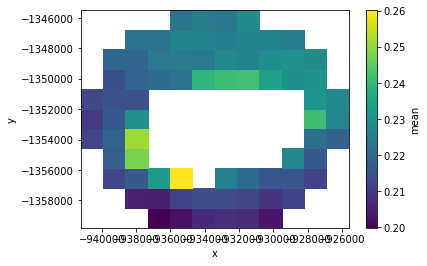

In [67]:
overallData['mean'].plot()

In [68]:
overallData.to_netcdf(path='/home/547/zxh547/dea-notebooks/overallData_CHL.nc')

**plot the spatial distribution of the CHL long-term mean; the black dots indicate that the pixels have observation frequency > 30% of the time-series**

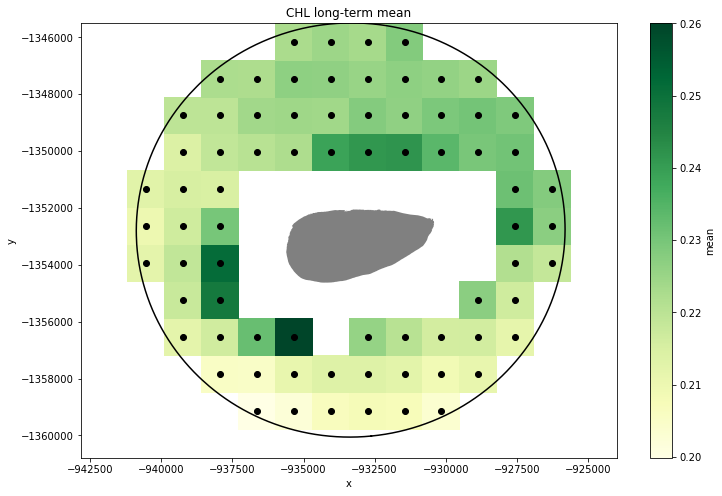

In [156]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(12,8))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(12,8),color='gray')

overallData['mean'].plot(cmap='YlGn')
plt.axis('equal')
plt.title('CHL long-term mean')
tempDF = overallDF[overallDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
figName = "overallMeanTest_CHL.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

## **add season and month columns**

In [70]:
seasonList = []
monthList = []
for date in chlDF.index:
    month = date[4:6]
    monthList.append(month)
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    seasonList.append(season)
chlDF['season'] = seasonList
chlDF['month'] = monthList

In [71]:
chlDF['20100902':'20101203']

1   2   3   4   5   6   7   8   9  10  ...  150  151  152  153  \
date                                              ...                       
20100902 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20100903 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20100904 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20100905 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20100906 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
...       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...   
20101129 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20101130 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20101201 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20101202 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
20101203 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   

          154  155  156  year  season  month  
date                                          
20100902  NaN  NaN  NaN  2010  spring     09  
20100903  NaN  NaN  NaN  2010  spring     09  
20100904  NaN  NaN  NaN  2010  spring     09  
20100905  NaN  NaN  NaN  2010  spring     09  
20100906  NaN  NaN  NaN  2010  spring     09  
...       ...  ...  ...   ...     ...    ...  
20101129  NaN  NaN  NaN  2010  spring     11  
20101130  NaN  NaN  NaN  2010  spring     11  
20101201  NaN  NaN  NaN  2010  summer     12  
20101202  NaN  NaN  NaN  2010  summer     12  
20101203  NaN  NaN  NaN  2010  summer     12  

[93 rows x 159 columns]

**seasonal statistics (e.g., mean, std, etc) for each valid pixels**

In [72]:
winterCHLDF = pd.DataFrame()
springCHLDF = pd.DataFrame()
summerCHLDF = pd.DataFrame()
autumnCHLDF = pd.DataFrame()
wi_meanList = []
wi_stdList = []
wi_countList = []
wi_freqList = []
sp_meanList = []
sp_stdList = []
sp_countList = []
sp_freqList = []
su_meanList = []
su_stdList = []
su_countList = []
su_freqList = []
au_meanList = []
au_stdList = []
au_countList = []
au_freqList = []

idList = []
for col in chlDF.columns:
    print(col)
    if col.isdigit():
             
        nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
        if nuData > 0:            
            x = chlDF[col].groupby(chlDF['season']) # groupby season
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            wi_mean = xDF.loc['winter']['mean']
            wi_std = xDF.loc['winter']['std']
            wi_count = xDF.loc['winter']['count']
            wi_freq = xDF.loc['winter']['count'] / (chlDF['season']=='winter').sum()
            
            sp_mean = xDF.loc['spring']['mean']
            sp_std = xDF.loc['spring']['std']
            sp_count = xDF.loc['spring']['count']
            sp_freq = xDF.loc['spring']['count'] / (chlDF['season']=='spring').sum()
            
            su_mean = xDF.loc['summer']['mean']
            su_std = xDF.loc['summer']['std']
            su_count = xDF.loc['summer']['count']
            su_freq = xDF.loc['summer']['count'] / (chlDF['season']=='summer').sum()
            
            au_mean = xDF.loc['autumn']['mean']
            au_std = xDF.loc['autumn']['std']
            au_count = xDF.loc['autumn']['count']
            au_freq = xDF.loc['autumn']['count'] / (chlDF['season']=='autumn').sum()
            
            idList.append(col)
            
            wi_meanList.append(wi_mean)
            wi_stdList.append(wi_std)
            wi_countList.append(wi_count)
            wi_freqList.append(wi_freq)
            
            sp_meanList.append(sp_mean)
            sp_stdList.append(sp_std)
            sp_countList.append(sp_count)
            sp_freqList.append(sp_freq)
            
            su_meanList.append(su_mean)
            su_stdList.append(su_std)
            su_countList.append(su_count)
            su_freqList.append(su_freq)
            
            au_meanList.append(au_mean)
            au_stdList.append(au_std)
            au_countList.append(au_count)
            au_freqList.append(au_freq)
            
winterCHLDF['id'] = idList
winterCHLDF['mean'] = wi_meanList
winterCHLDF['std'] = wi_stdList
winterCHLDF['count'] = wi_countList
winterCHLDF['frequency'] = wi_freqList
winterCHLDF.set_index('id',inplace=True)

springCHLDF['id'] = idList
springCHLDF['mean'] = sp_meanList
springCHLDF['std'] = sp_stdList
springCHLDF['count'] = sp_countList
springCHLDF['frequency'] = sp_freqList
springCHLDF.set_index('id',inplace=True)

summerCHLDF['id'] = idList
summerCHLDF['mean'] = su_meanList
summerCHLDF['std'] = su_stdList
summerCHLDF['count'] = su_countList
summerCHLDF['frequency'] = su_freqList
summerCHLDF.set_index('id',inplace=True)

autumnCHLDF['id'] = idList
autumnCHLDF['mean'] = au_meanList
autumnCHLDF['std'] = au_stdList
autumnCHLDF['count'] = au_countList
autumnCHLDF['frequency'] = au_freqList
autumnCHLDF.set_index('id',inplace=True)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
year
season
month


**add x and y to the seasonal dataframes**

In [73]:
xList = []
yList = []
for id in winterCHLDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
winterCHLDF['x'] = xList
winterCHLDF['y'] = yList

springCHLDF['x'] = xList
springCHLDF['y'] = yList

summerCHLDF['x'] = xList
summerCHLDF['y'] = yList

autumnCHLDF['x'] = xList
autumnCHLDF['y'] = yList

In [74]:
autumnCHLDF

mean       std  count  frequency       x        y
id                                                        
17   0.182431  0.109073  575.0   0.367647 -935350 -1346150
18   0.185965  0.114182  584.0   0.373402 -934050 -1346150
19   0.183928  0.110600  597.0   0.381714 -932750 -1346150
20   0.199374  0.169518  578.0   0.369565 -931450 -1346150
27   0.181843  0.116147  581.0   0.371483 -937950 -1347450
..        ...       ...    ...        ...     ...      ...
137  0.154937  0.106188  580.0   0.370844 -935350 -1359150
138  0.165372  0.143113  582.0   0.372123 -934050 -1359150
139  0.165475  0.130135  576.0   0.368286 -932750 -1359150
140  0.164043  0.126772  579.0   0.370205 -931450 -1359150
141  0.165659  0.122507  564.0   0.360614 -930150 -1359150

[74 rows x 6 columns]

**convert dataframes to xarry datasets and export them as netcdf files**

In [75]:
import xarray as xr
winterCHLDF1 = winterCHLDF.copy()
winterCHLDF1.set_index(['y','x'],inplace=True)
winterCHLData = xr.Dataset.from_dataframe(winterCHLDF1)
winterCHLData.attrs['crs']='EPSG:3577'
winterCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/winterCHLData.nc')

springCHLDF1 = springCHLDF.copy()
springCHLDF1.set_index(['y','x'],inplace=True)
springCHLData = xr.Dataset.from_dataframe(springCHLDF1)
springCHLData.attrs['crs']='EPSG:3577'
springCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/springCHLData.nc')

summerCHLDF1 = summerCHLDF.copy()
summerCHLDF1.set_index(['y','x'],inplace=True)
summerCHLData = xr.Dataset.from_dataframe(summerCHLDF1)
summerCHLData.attrs['crs']='EPSG:3577'
summerCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/summerCHLData.nc')

autumnCHLDF1 =autumnCHLDF.copy()
autumnCHLDF1.set_index(['y','x'],inplace=True)
autumnCHLData = xr.Dataset.from_dataframe(autumnCHLDF1)
autumnCHLData.attrs['crs']='EPSG:3577'
autumnCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/autumnCHLData.nc')

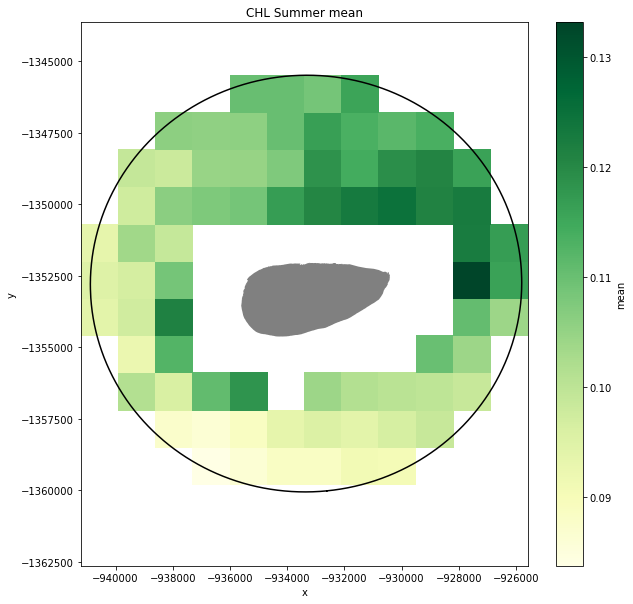

In [76]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(10,10))
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray')
summerCHLData['mean'].plot(cmap='YlGn')
for shape in LH.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
plt.title('CHL Summer mean')
figName = "winterMeanTest_CHL.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**display spatial distributions of seasonal mean; the black dots indicate the observation frequency greater than 30%**

In [77]:
winterCHLData['mean'].min().values

array(0.30611086)

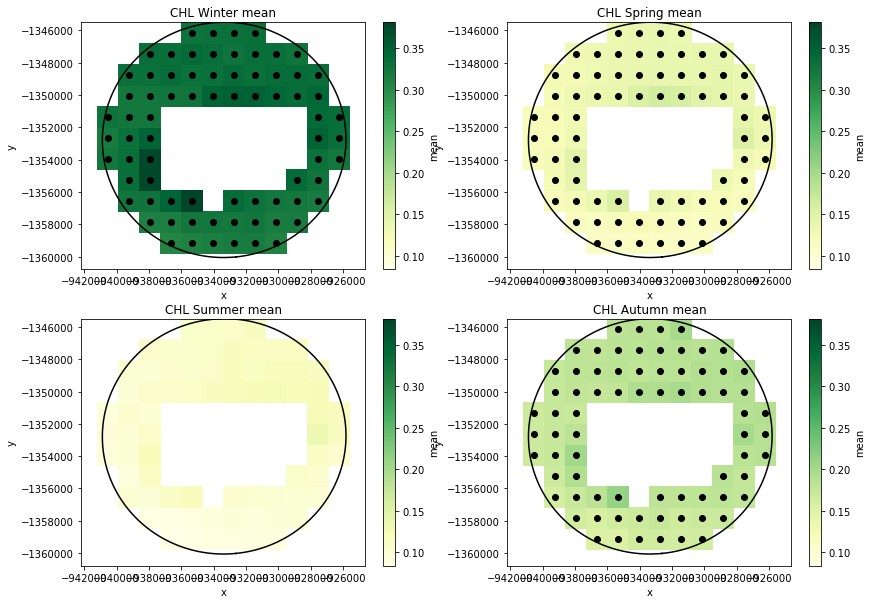

In [78]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,10))

x = [winterCHLData['mean'].min().values,summerCHLData['mean'].min().values,springCHLData['mean'].min().values,autumnCHLData['mean'].min().values]
minV = min(x)
x = [winterCHLData['mean'].max().values,summerCHLData['mean'].max().values,springCHLData['mean'].max().values,
     autumnCHLData['mean'].max().values]
maxV = max(x)

plt.subplot(2,2,1)
# shape_plot = gpd.read_file(reef_path)
# shape_plot.plot(figsize=(3,3),color='gray')
winterCHLData['mean'].plot(cmap='YlGn',vmax=maxV,vmin=minV)
plt.title('CHL Winter mean')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF = winterCHLDF[winterCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')


plt.subplot(2,2,2)
springCHLData['mean'].plot(cmap='YlGn',vmax=maxV,vmin=minV)
plt.title('CHL Spring mean')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF = springCHLDF[springCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(2,2,3)
summerCHLData['mean'].plot(cmap='YlGn',vmax=maxV,vmin=minV)
plt.title('CHL Summer mean')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF = summerCHLDF[summerCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(2,2,4)
autumnCHLData['mean'].plot(cmap='YlGn',vmax=maxV,vmin=minV)
plt.title('CHL Autumn mean')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =autumnCHLDF[autumnCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

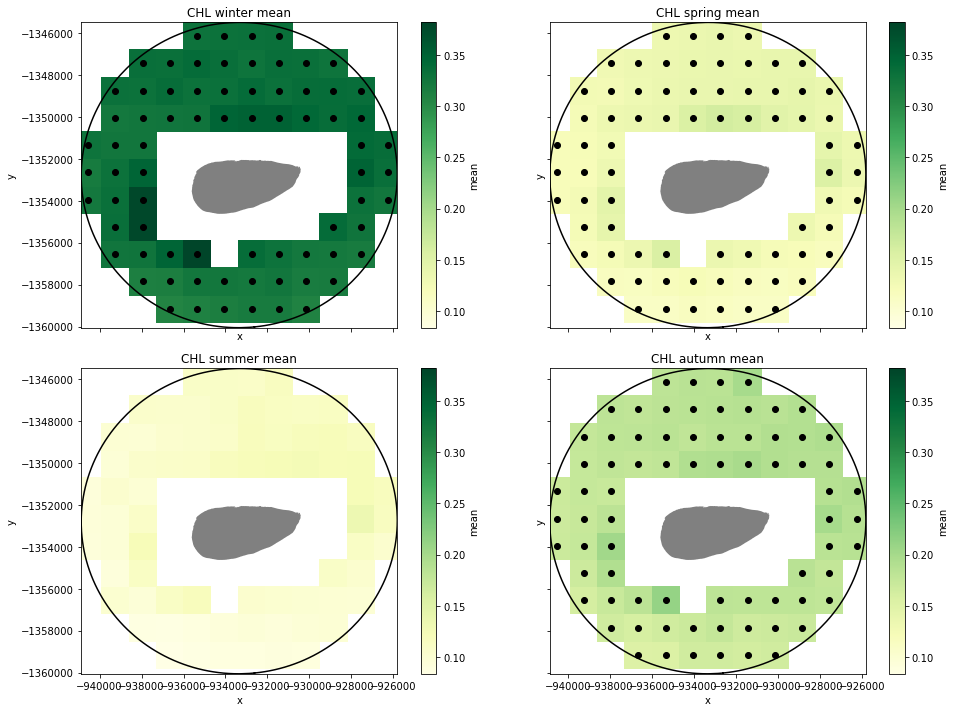

In [79]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

x=[winterCHLData['mean'].min().values,summerCHLData['mean'].min().values,
  springCHLData['mean'].min().values,autumnCHLData['mean'].min().values]
minV = min(x)
x=[winterCHLData['mean'].max().values,summerCHLData['mean'].max().values,
  springCHLData['mean'].max().values,autumnCHLData['mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,0])

winterCHLData['mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('CHL winter mean')
#axes[0,0].axis('equal')

tempDF = winterCHLDF[winterCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,1])
springCHLData['mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('CHL spring mean')
#axes[0,1].axis('equal')

tempDF = springCHLDF[springCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,0])
summerCHLData['mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('CHL summer mean')
#axes[1,0].axis('equal')

tempDF = summerCHLDF[summerCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,1])
autumnCHLData['mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('CHL autumn mean')
#axes[1,1].axis('equal')

tempDF = autumnCHLDF[autumnCHLDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**A conveinent function for calculating CHL monthly statistics**

In [80]:
def monthDF(month):
    meanList = []
    stdList = []
    countList = []
    freqList = []
    idList = []
    tempDF = pd.DataFrame()
    for col in chlDF.columns:
        if col.isdigit():
            nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
            if nuData > 0:            
                x = chlDF[col].groupby(chlDF['month']) # groupby month
                xDF = x.describe() # a DataFrame containing the results of the groupby operation
                mean = xDF.loc[month]['mean']
                std = xDF.loc[month]['std']
                count = xDF.loc[month]['count']
                freq = xDF.loc[month]['count'] / (chlDF['month']==month).sum() 

                idList.append(col)

                meanList.append(mean)
                stdList.append(std)
                countList.append(count)
                freqList.append(freq)
    tempDF['id'] = idList
    tempDF['mean'] = meanList
    tempDF['std'] = stdList
    tempDF['count'] = countList
    tempDF['freq'] = freqList
    tempDF.set_index('id',inplace=True)
    return tempDF


    

**calculate monthly statistics for each valid pixel**

In [81]:
JanCHLDF = monthDF('01')
FebCHLDF = monthDF('02')
MarCHLDF = monthDF('03')
AprCHLDF = monthDF('04')
MayCHLDF = monthDF('05')
JunCHLDF = monthDF('06')
JulCHLDF = monthDF('07')
AugCHLDF = monthDF('08')
SepCHLDF = monthDF('09')
OctCHLDF = monthDF('10')
NovCHLDF = monthDF('11')
DecCHLDF = monthDF('12')
             

        

In [82]:
DecCHLDF

mean       std  count      freq
id                                      
17   0.089336  0.034189   56.0  0.106667
18   0.088399  0.043063   57.0  0.108571
19   0.090844  0.053115   59.0  0.112381
20   0.093392  0.046984   63.0  0.120000
27   0.098484  0.070500   51.0  0.097143
..        ...       ...    ...       ...
137  0.073479  0.040872   55.0  0.104762
138  0.077411  0.041750   56.0  0.106667
139  0.073887  0.034898   61.0  0.116190
140  0.081468  0.040293   61.0  0.116190
141  0.083314  0.044702   67.0  0.127619

[74 rows x 4 columns]

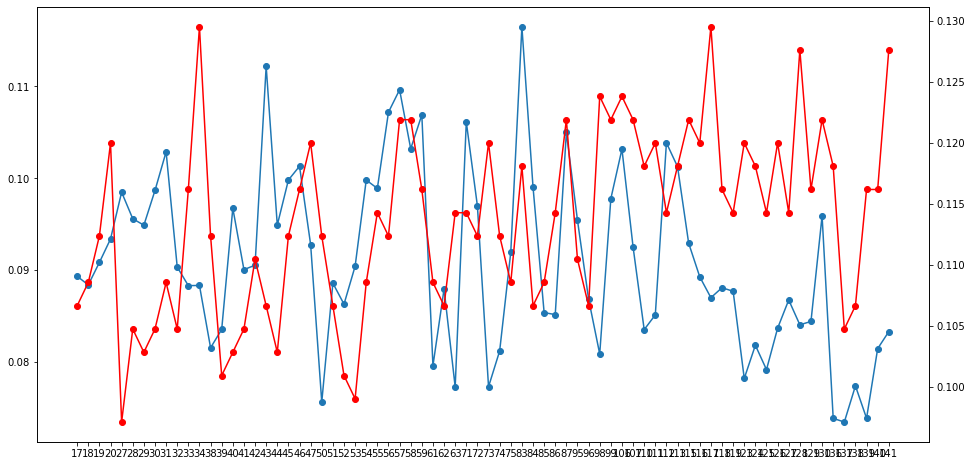

In [83]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(DecCHLDF.index,DecCHLDF['mean'],marker='o')
ax2.plot(DecCHLDF.index,DecCHLDF['freq'],color='red',marker='o')

In [84]:
xList = []
yList = []
for id in JanCHLDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
JanCHLDF['x'] = xList
JanCHLDF['y'] = yList
FebCHLDF['x'] = xList
FebCHLDF['y'] = yList
MarCHLDF['x'] = xList
MarCHLDF['y'] = yList
AprCHLDF['x'] = xList
AprCHLDF['y'] = yList
MayCHLDF['x'] = xList
MayCHLDF['y'] = yList
JunCHLDF['x'] = xList
JunCHLDF['y'] = yList
JulCHLDF['x'] = xList
JulCHLDF['y'] = yList
AugCHLDF['x'] = xList
AugCHLDF['y'] = yList
SepCHLDF['x'] = xList
SepCHLDF['y'] = yList
OctCHLDF['x'] = xList
OctCHLDF['y'] = yList
NovCHLDF['x'] = xList
NovCHLDF['y'] = yList
DecCHLDF['x'] = xList
DecCHLDF['y'] = yList



In [85]:
JanCHLDF

mean       std  count      freq       x        y
id                                                       
17   0.112039  0.055311   54.0  0.102467 -935350 -1346150
18   0.113309  0.049747   52.0  0.098672 -934050 -1346150
19   0.107028  0.051361   47.0  0.089184 -932750 -1346150
20   0.119556  0.045638   50.0  0.094877 -931450 -1346150
27   0.103427  0.051267   51.0  0.096774 -937950 -1347450
..        ...       ...    ...       ...     ...      ...
137  0.091283  0.043050   56.0  0.106262 -935350 -1359150
138  0.097087  0.048480   53.0  0.100569 -934050 -1359150
139  0.097531  0.050555   55.0  0.104364 -932750 -1359150
140  0.098510  0.050279   52.0  0.098672 -931450 -1359150
141  0.098871  0.049147   53.0  0.100569 -930150 -1359150

[74 rows x 6 columns]

In [86]:
import xarray as xr
JanCHLDF1 = JanCHLDF.copy()
JanCHLDF1.set_index(['y','x'],inplace=True)
JanCHLData = xr.Dataset.from_dataframe(JanCHLDF1)
JanCHLData.attrs['crs']='EPSG:3577'
JanCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/JanCHLData.nc')

import xarray as xr
FebCHLDF1 = FebCHLDF.copy()
FebCHLDF1.set_index(['y','x'],inplace=True)
FebCHLData = xr.Dataset.from_dataframe(FebCHLDF1)
FebCHLData.attrs['crs']='EPSG:3577'
FebCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/FebCHLData.nc')

import xarray as xr
MarCHLDF1 = MarCHLDF.copy()
MarCHLDF1.set_index(['y','x'],inplace=True)
MarCHLData = xr.Dataset.from_dataframe(MarCHLDF1)
MarCHLData.attrs['crs']='EPSG:3577'
MarCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/MarCHLData.nc')

import xarray as xr
AprCHLDF1 = AprCHLDF.copy()
AprCHLDF1.set_index(['y','x'],inplace=True)
AprCHLData = xr.Dataset.from_dataframe(AprCHLDF1)
AprCHLData.attrs['crs']='EPSG:3577'
AprCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/AprCHLData.nc')

import xarray as xr
MayCHLDF1 = MayCHLDF.copy()
MayCHLDF1.set_index(['y','x'],inplace=True)
MayCHLData = xr.Dataset.from_dataframe(MayCHLDF1)
MayCHLData.attrs['crs']='EPSG:3577'
MayCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/MayCHLData.nc')

import xarray as xr
JunCHLDF1 = JunCHLDF.copy()
JunCHLDF1.set_index(['y','x'],inplace=True)
JunCHLData = xr.Dataset.from_dataframe(JunCHLDF1)
JunCHLData.attrs['crs']='EPSG:3577'
JunCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/JunCHLData.nc')

import xarray as xr
JulCHLDF1 = JulCHLDF.copy()
JulCHLDF1.set_index(['y','x'],inplace=True)
JulCHLData = xr.Dataset.from_dataframe(JulCHLDF1)
JulCHLData.attrs['crs']='EPSG:3577'
JulCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/JulCHLData.nc')

import xarray as xr
AugCHLDF1 = AugCHLDF.copy()
AugCHLDF1.set_index(['y','x'],inplace=True)
AugCHLData = xr.Dataset.from_dataframe(AugCHLDF1)
AugCHLData.attrs['crs']='EPSG:3577'
AugCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/AugCHLData.nc')

import xarray as xr
SepCHLDF1 = SepCHLDF.copy()
SepCHLDF1.set_index(['y','x'],inplace=True)
SepCHLData = xr.Dataset.from_dataframe(SepCHLDF1)
SepCHLData.attrs['crs']='EPSG:3577'
SepCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/SepCHLData.nc')

import xarray as xr
OctCHLDF1 = OctCHLDF.copy()
OctCHLDF1.set_index(['y','x'],inplace=True)
OctCHLData = xr.Dataset.from_dataframe(OctCHLDF1)
OctCHLData.attrs['crs']='EPSG:3577'
OctCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/OctCHLData.nc')

import xarray as xr
NovCHLDF1 = NovCHLDF.copy()
NovCHLDF1.set_index(['y','x'],inplace=True)
NovCHLData = xr.Dataset.from_dataframe(NovCHLDF1)
NovCHLData.attrs['crs']='EPSG:3577'
NovCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/NovCHLData.nc')

import xarray as xr
DecCHLDF1 = DecCHLDF.copy()
DecCHLDF1.set_index(['y','x'],inplace=True)
DecCHLData = xr.Dataset.from_dataframe(DecCHLDF1)
DecCHLData.attrs['crs']='EPSG:3577'
DecCHLData.to_netcdf(path='/home/547/zxh547/dea-notebooks/DecCHLData.nc')

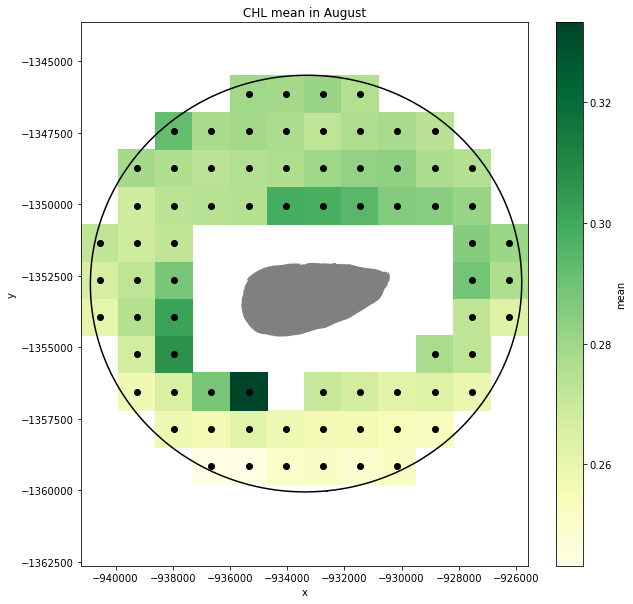

In [87]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(10,10))
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray')
AugCHLData['mean'].plot(cmap='YlGn')
for shape in LH.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.title('CHL mean in August')
plt.axis('equal')
tempDF =AugCHLDF[AugCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

figName = "AugMeanTest.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**display spatial distributions of CHL monthly mean; the black dots indicate observation frequency greater than 30%**

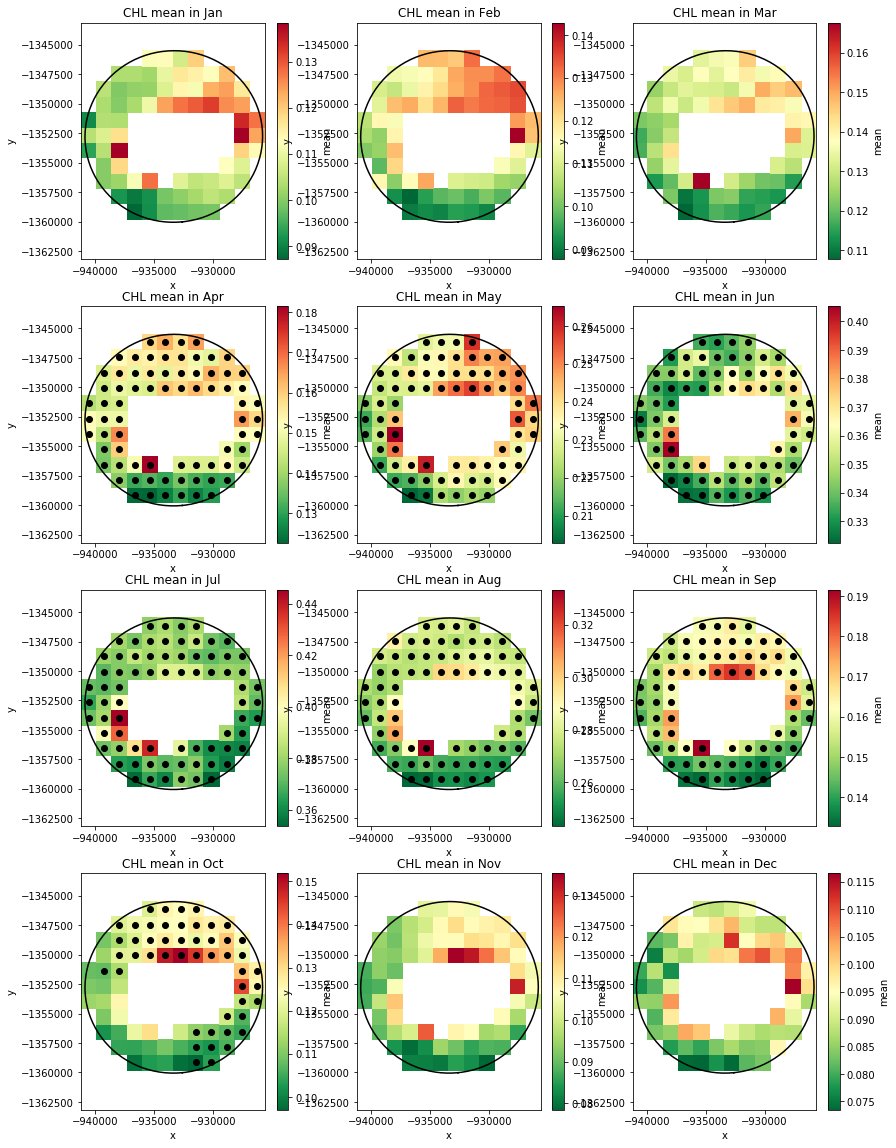

In [88]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(4,3,1)
JanCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Jan')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =JanCHLDF[JanCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,2)
FebCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Feb')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =FebCHLDF[FebCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,3)
MarCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Mar')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =MarCHLDF[MarCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,4)
AprCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Apr')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF = AprCHLDF[AprCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,5)
MayCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in May')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =MayCHLDF[MayCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,6)
JunCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Jun')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =JunCHLDF[JunCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,7)
JulCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Jul')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =JulCHLDF[JulCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,8)
AugCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Aug')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =AugCHLDF[AugCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,9)
SepCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Sep')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =SepCHLDF[SepCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,10)
OctCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Oct')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =OctCHLDF[OctCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,11)
NovCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Nov')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =NovCHLDF[NovCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

plt.subplot(4,3,12)
DecCHLData['mean'].plot(cmap='RdYlGn_r')
plt.title('CHL mean in Dec')
plt.axis('equal')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
tempDF =DecCHLDF[DecCHLDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')    


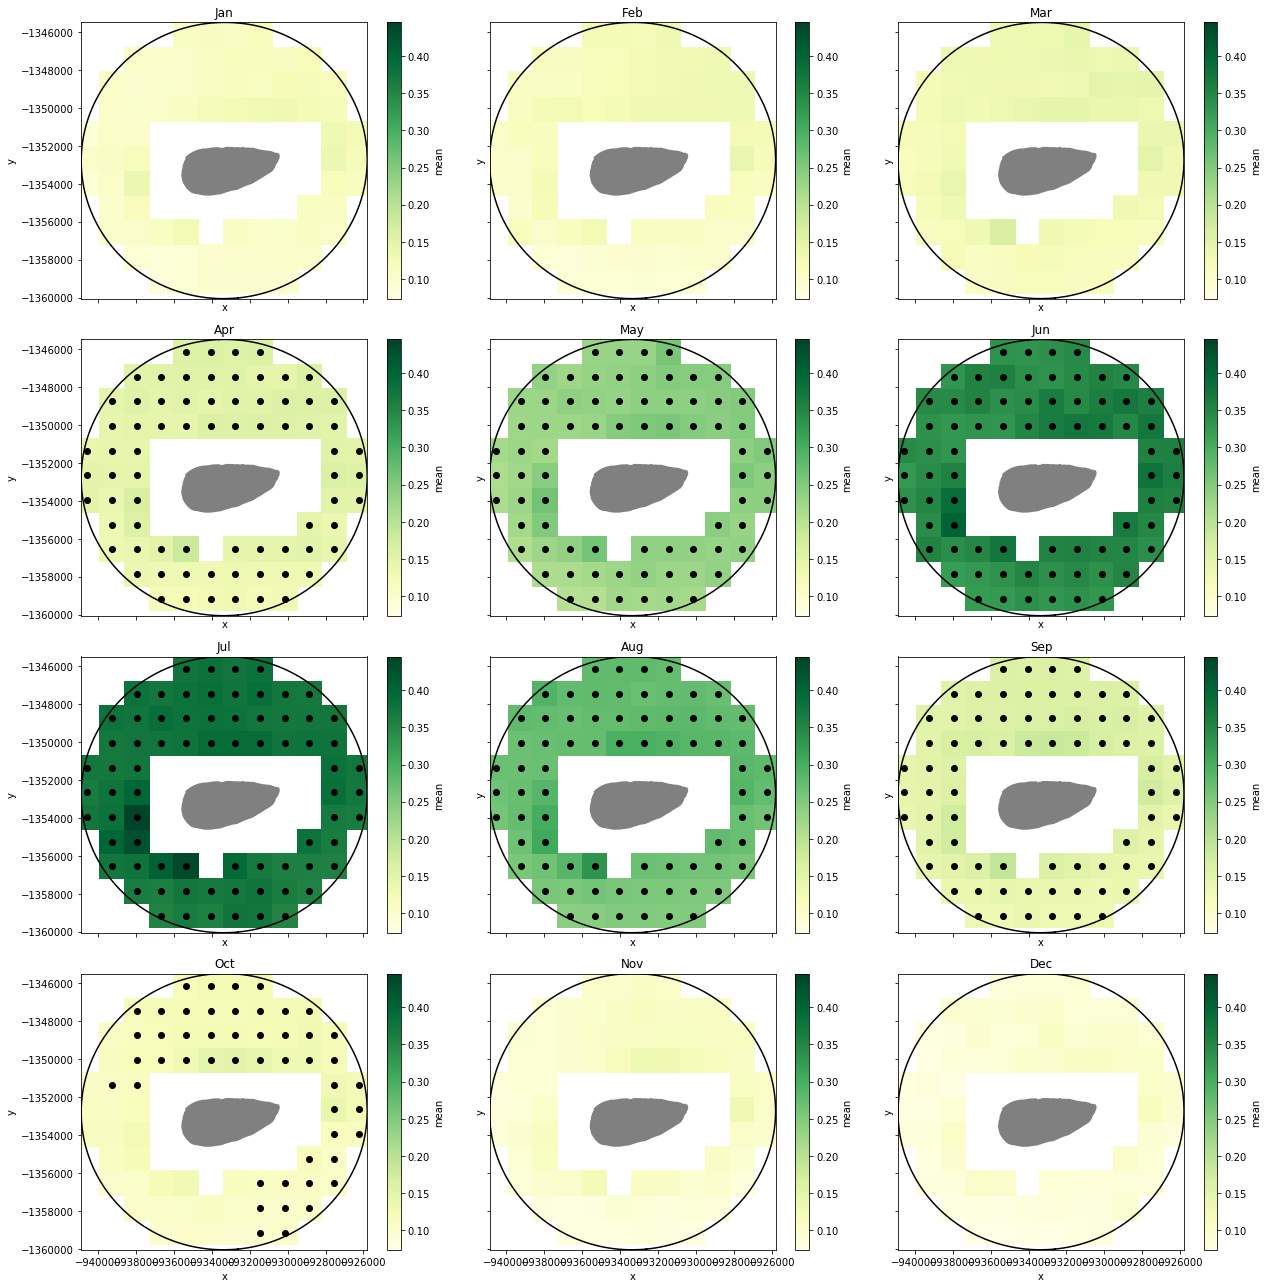

In [157]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

x=[JanCHLData['mean'].min().values,FebCHLData['mean'].min().values,
  MarCHLData['mean'].min().values,AprCHLData['mean'].min().values,
  MayCHLData['mean'].min().values,JunCHLData['mean'].min().values,
  JulCHLData['mean'].min().values,AugCHLData['mean'].min().values,
  SepCHLData['mean'].min().values,OctCHLData['mean'].min().values,
  NovCHLData['mean'].min().values,DecCHLData['mean'].min().values]
minV = min(x)
x=[JanCHLData['mean'].max().values,FebCHLData['mean'].max().values,
  MarCHLData['mean'].max().values,AprCHLData['mean'].max().values,
  MayCHLData['mean'].max().values,JunCHLData['mean'].max().values,
  JulCHLData['mean'].max().values,AugCHLData['mean'].max().values,
  SepCHLData['mean'].max().values,OctCHLData['mean'].max().values,
  NovCHLData['mean'].max().values,DecCHLData['mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

    
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(18,18))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])
JanCHLData['mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('Jan')
tempDF = JanCHLDF[JanCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
FebCHLData['mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('Feb')
tempDF = FebCHLDF[FebCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,2])
MarCHLData['mean'].plot(cmap=colormap,ax=axes[0,2],vmin=minV,vmax=maxV)
axes[0,2].set_title('Mar')
tempDF = MarCHLDF[MarCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
AprCHLData['mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('Apr')
tempDF = AprCHLDF[AprCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
MayCHLData['mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('May')
tempDF = MayCHLDF[MayCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,2])
JunCHLData['mean'].plot(cmap=colormap,ax=axes[1,2],vmin=minV,vmax=maxV)
axes[1,2].set_title('Jun')
tempDF = JunCHLDF[JunCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,0])
JulCHLData['mean'].plot(cmap=colormap,ax=axes[2,0],vmin=minV,vmax=maxV)
axes[2,0].set_title('Jul')
tempDF = JulCHLDF[JulCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,1])
AugCHLData['mean'].plot(cmap=colormap,ax=axes[2,1],vmin=minV,vmax=maxV)
axes[2,1].set_title('Aug')
tempDF = AugCHLDF[AugCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,2])
SepCHLData['mean'].plot(cmap=colormap,ax=axes[2,2],vmin=minV,vmax=maxV)
axes[2,2].set_title('Sep')
tempDF = SepCHLDF[SepCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,0])
OctCHLData['mean'].plot(cmap=colormap,ax=axes[3,0],vmin=minV,vmax=maxV)
axes[3,0].set_title('Oct')
tempDF = OctCHLDF[OctCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,1])
NovCHLData['mean'].plot(cmap=colormap,ax=axes[3,1],vmin=minV,vmax=maxV)
axes[3,1].set_title('Nov')
tempDF = NovCHLDF[NovCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,2])
DecCHLData['mean'].plot(cmap=colormap,ax=axes[3,2],vmin=minV,vmax=maxV)
axes[3,2].set_title('Dec')
tempDF = DecCHLDF[DecCHLDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**function for generating annual time-series of seasonal mean for each valid pixel**

In [90]:
def yearseasonCHL(season):
    tempDF = pd.DataFrame()
    for col in chlDF.columns:
        
        if col.isdigit():
            
            nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
            if nuData > 0:
                x = chlDF[chlDF['season'] == season]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

In [91]:
yearwinterDF = yearseasonCHL('winter')
yearspringDF = yearseasonCHL('spring')
yearsummerDF = yearseasonCHL('summer')
yearautumnDF = yearseasonCHL('autumn')

In [92]:
# years 2002 and 2019 do not contain a full summer season
# summer months 12, 1 and 2 expand two years, this is another issue
yearsummerDF1 = yearsummerDF.loc['2003':'2018']

In [93]:
yearwinterDF

17        18        19        20        27        28        29  \
year                                                                         
2002  0.242276  0.261276  0.251538  0.252896  0.240591  0.245407  0.275623   
2003  0.317317  0.314792  0.318754  0.308801  0.316681  0.307883  0.319118   
2004  0.359036  0.367522  0.361956  0.473169  0.376784  0.477791  0.360617   
2005  0.288579  0.302354  0.308351  0.332125  0.294739  0.284323  0.322805   
2006  0.414489  0.410878  0.405811  0.419990  0.401422  0.401483  0.412445   
2007  0.304858  0.299743  0.304964  0.292107  0.289040  0.309610  0.322700   
2008  0.370926  0.364989  0.382338  0.368283  0.365800  0.362022  0.383081   
2009  0.224452  0.238586  0.232833  0.230776  0.219395  0.217584  0.228230   
2010  0.286608  0.289219  0.286637  0.280783  0.289085  0.302712  0.279801   
2011  0.337521  0.349470  0.336251  0.314688  0.367355  0.363874  0.335529   
2012  0.350119  0.350468  0.353115  0.349320  0.372954  0.357044  0.333375   
2013  0.314744  0.307115  0.321820  0.299693  0.325978  0.305019  0.329862   
2014  0.383068  0.359210  0.373056  0.372472  0.438356  0.370982  0.474591   
2015  0.308827  0.302176  0.326665  0.332791  0.314591  0.316894  0.320464   
2016  0.309851  0.324778  0.290008  0.292098  0.278846  0.298575  0.296253   
2017  0.291465  0.281927  0.286694  0.285882  0.297899  0.288958  0.299254   
2018  0.370824  0.373543  0.360712  0.338870  0.366318  0.352739  0.356409   
2019  0.491598  0.497516  0.487770  0.490539  0.497112  0.477665  0.476506   

            30        31        32  ...       127       128       129  \
year                                ...                                 
2002  0.273692  0.249802  0.241978  ...  0.230243  0.227008  0.229282   
2003  0.315578  0.312057  0.321947  ...  0.281731  0.290346  0.286259   
2004  0.360782  0.342404  0.446429  ...  0.445858  0.454357  0.351543   
2005  0.299159  0.310309  0.306907  ...  0.300473  0.293155  0.292205   
2006  0.422679  0.406358  0.422038  ...  0.393863  0.425024  0.416660   
2007  0.329364  0.316427  0.313025  ...  0.276601  0.296865  0.285636   
2008  0.377313  0.379150  0.369244  ...  0.359321  0.367307  0.362258   
2009  0.242263  0.227633  0.240544  ...  0.241490  0.240932  0.239626   
2010  0.284539  0.282352  0.287253  ...  0.310436  0.316235  0.303268   
2011  0.329674  0.328202  0.330032  ...  0.345221  0.343253  0.323944   
2012  0.336163  0.343251  0.341327  ...  0.304878  0.301564  0.319050   
2013  0.340445  0.322277  0.310581  ...  0.280458  0.283592  0.274413   
2014  0.367643  0.371534  0.366366  ...  0.350649  0.359163  0.340424   
2015  0.308613  0.311997  0.326460  ...  0.303745  0.302891  0.313971   
2016  0.295847  0.284522  0.293299  ...  0.262418  0.273716  0.266064   
2017  0.301637  0.296036  0.297350  ...  0.284028  0.282958  0.286833   
2018  0.363917  0.347425  0.354544  ...  0.367131  0.356429  0.359271   
2019  0.487062  0.489500  0.479781  ...  0.459694  0.472769  0.470725   

           130       136       137       138       139       140       141  
year                                                                        
2002  0.234335  0.205776  0.206861  0.214905  0.217255  0.213460  0.221094  
2003  0.280664  0.269704  0.272309  0.275563  0.275419  0.273431  0.269478  
2004  0.337407  0.364663  0.366324  0.363899  0.384580  0.384335  0.320374  
2005  0.313055  0.261866  0.276375  0.284390  0.282696  0.276128  0.275274  
2006  0.415709  0.402077  0.415497  0.390965  0.396620  0.434873  0.443245  
2007  0.283919  0.273180  0.266189  0.270972  0.278637  0.281797  0.275523  
2008  0.368194  0.362300  0.353114  0.358696  0.348964  0.356739  0.365226  
2009  0.240024  0.219426  0.229762  0.233387  0.254222  0.246161  0.242450  
2010  0.302947  0.292288  0.299126  0.326097  0.295707  0.298338  0.305069  
2011  0.322722  0.356324  0.333808  0.354133  0.333220  0.326164  0.315005  
2012  0.324015  0.288324  0.307561  0.305806  0.380755  0.341385  

**function for calculating trends of annual time-series of seasonal mean for each valid pixel**

In [94]:
import statsmodels.formula.api as sm
def yearseasonTrend(yearseasonDF,season):
    ind = np.arange(1,yearseasonDF.index.size+1,1)
    yearseasonDF['ind'] = ind
    yearseasonRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearseasonDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearseasonDF.index.size - np.isnan(yearseasonDF[col]).sum()
            f = x/yearseasonDF.index.size
            if f > 0.5:
                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearseasonDF, missing='drop').fit()

                predict = fit.predict(yearseasonDF)
                yearseasonDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearseasonRateDF['id'] = idList
    yearseasonRateDF['rate'] = rateList
    yearseasonRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = chlDF[chlDF['season'] == season]
    
    for col in yearseasonDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearseasonRateDF['count'] = countList
    yearseasonRateDF['frequency'] = freqList
    yearseasonRateDF.set_index("id",inplace=True)
    
    return yearseasonRateDF

In [95]:
yearwinterRateDF = yearseasonTrend(yearwinterDF,'winter')
yearspringRateDF = yearseasonTrend(yearspringDF,'spring')
yearsummerRateDF = yearseasonTrend(yearsummerDF1,'summer')
yearautumnRateDF = yearseasonTrend(yearautumnDF,'autumn')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
yearsummerRateDF

rate  pValue  count  frequency
id                                  
17  -0.001    0.52    185   0.120757
18  -0.000    0.92    186   0.121410
19  -0.002    0.09    185   0.120757
20   0.000    0.82    189   0.123368
27  -0.001    0.55    178   0.116188
..     ...     ...    ...        ...
137  0.001    0.60    184   0.120104
138 -0.000    0.88    178   0.116188
139  0.000    0.96    189   0.123368
140  0.000    0.88    186   0.121410
141 -0.000    0.85    196   0.127937

[74 rows x 4 columns]

In [97]:
xList = []
yList = []
for id in yearsummerRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearsummerRateDF['x'] = xList
yearsummerRateDF['y'] = yList
yearspringRateDF['x'] = xList
yearspringRateDF['y'] = yList
yearautumnRateDF['x'] = xList
yearautumnRateDF['y'] = yList
yearwinterRateDF['x'] = xList
yearwinterRateDF['y'] = yList


In [98]:
import xarray as xr
yearsummerRateDF1 = yearsummerRateDF.copy()
yearsummerRateDF1.set_index(['y','x'],inplace=True)
yearsummerRateData = xr.Dataset.from_dataframe(yearsummerRateDF1)
yearsummerRateData.attrs['crs']='EPSG:3577'
yearsummerRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearsummerRateData_CHL.nc')

import xarray as xr
yearspringRateDF1 = yearspringRateDF.copy()
yearspringRateDF1.set_index(['y','x'],inplace=True)
yearspringRateData = xr.Dataset.from_dataframe(yearspringRateDF1)
yearspringRateData.attrs['crs']='EPSG:3577'
yearspringRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearspringRateData_CHL.nc')

import xarray as xr
yearautumnRateDF1 = yearautumnRateDF.copy()
yearautumnRateDF1.set_index(['y','x'],inplace=True)
yearautumnRateData = xr.Dataset.from_dataframe(yearautumnRateDF1)
yearautumnRateData.attrs['crs']='EPSG:3577'
yearautumnRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearautumnRateData_CHL.nc')

import xarray as xr
yearwinterRateDF1 = yearwinterRateDF.copy()
yearwinterRateDF1.set_index(['y','x'],inplace=True)
yearwinterRateData = xr.Dataset.from_dataframe(yearwinterRateDF1)
yearwinterRateData.attrs['crs']='EPSG:3577'
yearwinterRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearwinterRateData_CHL.nc')

In [99]:
yearwinterRateData

<xarray.Dataset>
Dimensions:    (x: 12, y: 11)
Coordinates:
  * y          (y) int64 -1359150 -1357850 -1356550 ... -1347450 -1346150
  * x          (x) int64 -940550 -939250 -937950 ... -928850 -927550 -926250
Data variables:
    rate       (y, x) float64 nan nan nan 0.003 0.004 ... 0.001 nan nan nan nan
    pValue     (y, x) float64 nan nan nan 0.26 0.19 ... 0.65 nan nan nan nan
    count      (y, x) float64 nan nan nan 881.0 881.0 ... 860.0 nan nan nan nan
    frequency  (y, x) float64 nan nan nan 0.5608 0.5608 ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

**display spatial patterns of annual trends of seasonal means; the black dots indicate statistical signficance at 90% confidence level**

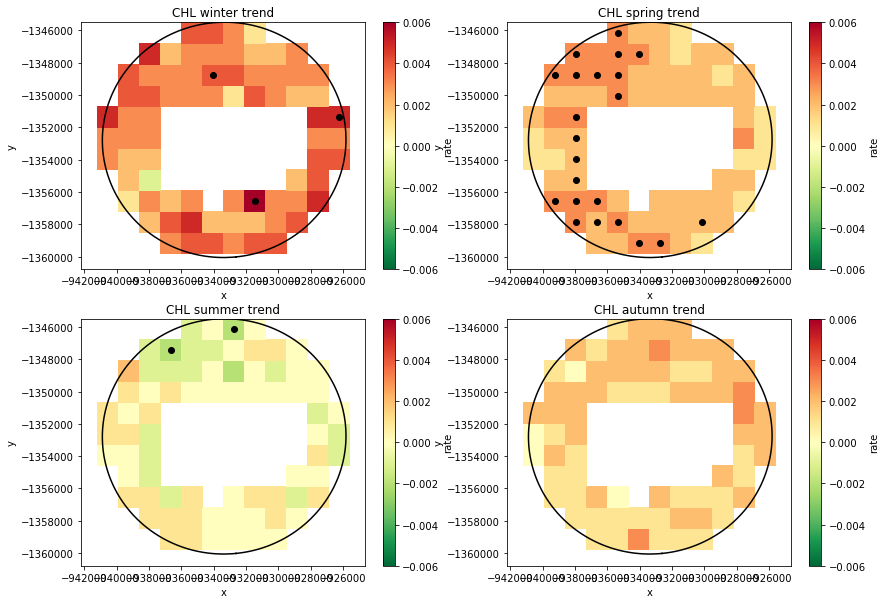

In [100]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

x=[yearwinterRateData['rate'].min().values,yearsummerRateData['rate'].min().values,
  yearspringRateData['rate'].min().values,yearautumnRateData['rate'].min().values]
minV = min(x)
x=[yearwinterRateData['rate'].max().values,yearsummerRateData['rate'].max().values,
  yearspringRateData['rate'].max().values,yearautumnRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
yearwinterRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL winter trend')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearwinterRateDF[yearwinterRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,2)
yearspringRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL spring trend')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearspringRateDF[yearspringRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,3)
yearsummerRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL summer trend')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearsummerRateDF[yearsummerRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,4)
yearautumnRateData['rate'].plot(cmap=colormap,vmin=minV,vmax=maxV)
plt.title('CHL autumn trend')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearautumnRateDF[yearautumnRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.show()

In [101]:
yearspringRateDF

rate  pValue  count  frequency       x        y
id                                                   
17   0.003    0.08    544   0.351648 -935350 -1346150
18   0.002    0.12    539   0.348416 -934050 -1346150
19   0.002    0.14    547   0.353588 -932750 -1346150
20   0.001    0.43    559   0.361345 -931450 -1346150
27   0.003    0.06    544   0.351648 -937950 -1347450
..     ...     ...    ...        ...     ...      ...
137  0.002    0.12    517   0.334195 -935350 -1359150
138  0.003    0.07    524   0.338720 -934050 -1359150
139  0.003    0.09    519   0.335488 -932750 -1359150
140  0.002    0.21    527   0.340659 -931450 -1359150
141  0.001    0.34    531   0.343245 -930150 -1359150

[74 rows x 6 columns]

**the same as above, except sharing X and Y axes**

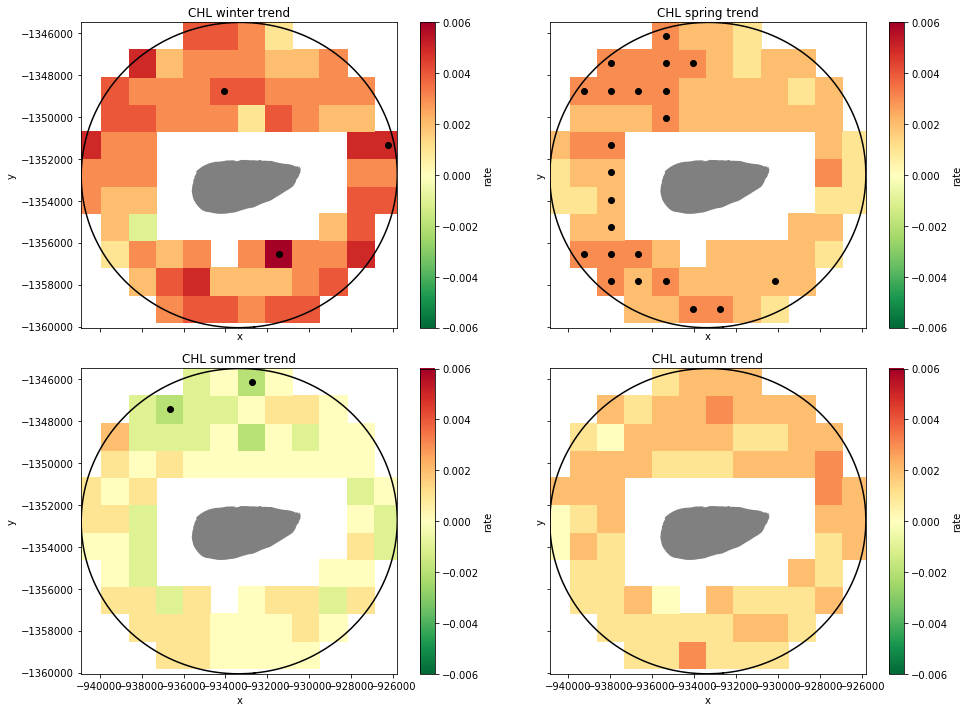

In [102]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

x=[yearwinterRateData['rate'].min().values,yearsummerRateData['rate'].min().values,
  yearspringRateData['rate'].min().values,yearautumnRateData['rate'].min().values]
minV = min(x)
x=[yearwinterRateData['rate'].max().values,yearsummerRateData['rate'].max().values,
  yearspringRateData['rate'].max().values,yearautumnRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,0])

yearwinterRateData['rate'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('CHL winter trend')
#axes[0,0].axis('equal')

tempDF = yearwinterRateDF[yearwinterRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,1])
yearspringRateData['rate'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('CHL spring trend')
#axes[0,1].axis('equal')

tempDF = yearspringRateDF[yearspringRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,0])
yearsummerRateData['rate'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('CHL summer trend')
#axes[1,0].axis('equal')

tempDF = yearsummerRateDF[yearsummerRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,1])
yearautumnRateData['rate'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('CHL autumn trend')
#axes[1,1].axis('equal')

tempDF = yearautumnRateDF[yearautumnRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)
#xmin = yearautumnRateData.x.min()
#xmax = yearautumnRateData.x.max()
#ymin = yearautumnRateData.y.min()
#ymax = yearautumnRateData.y.max()
#axes[0,0].axis([-942000,-924000,-1362000,-1344000])
axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**function for generating annual time-series of monthly mean for each valid pixel**

In [103]:
def yearmonthCHL(month):
    tempDF = pd.DataFrame()
    for col in chlDF.columns:
        
        if col.isdigit():
            
            nuData = chlDF.index.size - np.isnan(chlDF[col]).sum()
            if nuData > 0:
                x = chlDF[chlDF['month'] == month]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

**function for calculating trends of annual time-series of monthly mean for each valid pixel**

In [104]:
import statsmodels.formula.api as sm
def yearmonthTrend(yearmonthDF,month):
    ind = np.arange(1,yearmonthDF.index.size+1,1)
    yearmonthDF['ind'] = ind
    yearmonthRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearmonthDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearmonthDF.index.size - np.isnan(yearmonthDF[col]).sum()
            f = x/yearmonthDF.index.size
            # only calculate trend when the observation frequency is greater than 50%
            if f > 0.5:
                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearmonthDF, missing='drop').fit()

                predict = fit.predict(yearmonthDF)
                yearmonthDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearmonthRateDF['id'] = idList
    yearmonthRateDF['rate'] = rateList
    yearmonthRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = chlDF[chlDF['month'] == month]
    
    for col in yearmonthDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearmonthRateDF['count'] = countList
    yearmonthRateDF['frequency'] = freqList
    yearmonthRateDF.set_index("id",inplace=True)
    
    return yearmonthRateDF

**calculate annual time-series of monthly means and their trends**

In [105]:
yearJanDF = yearmonthCHL('01')
yearJanRateDF = yearmonthTrend(yearJanDF,'01')
yearFebDF = yearmonthCHL('02')
yearFebRateDF = yearmonthTrend(yearFebDF,'02')
yearMarDF = yearmonthCHL('03')
yearMarRateDF = yearmonthTrend(yearMarDF,'03')
yearAprDF = yearmonthCHL('04')
yearAprRateDF = yearmonthTrend(yearAprDF,'04')
yearMayDF = yearmonthCHL('05')
yearMayRateDF = yearmonthTrend(yearMayDF,'05')
yearJunDF = yearmonthCHL('06')
yearJunRateDF = yearmonthTrend(yearJunDF,'06')
yearJulDF = yearmonthCHL('07')
yearJulRateDF = yearmonthTrend(yearJulDF,'07')
yearAugDF = yearmonthCHL('08')
yearAugRateDF = yearmonthTrend(yearAugDF,'08')
yearSepDF = yearmonthCHL('09')
yearSepRateDF = yearmonthTrend(yearSepDF,'09')
yearOctDF = yearmonthCHL('10')
yearOctRateDF = yearmonthTrend(yearOctDF,'10')
yearNovDF = yearmonthCHL('11')
yearNovRateDF = yearmonthTrend(yearNovDF,'11')
yearDecDF = yearmonthCHL('12')
yearDecRateDF = yearmonthTrend(yearDecDF,'12')

In [106]:
yearFebRateDF

rate  pValue  count  frequency
id                                  
17  -0.003    0.19     75   0.156250
18  -0.003    0.15     77   0.160417
19  -0.004    0.05     79   0.164583
20  -0.002    0.29     76   0.158333
27  -0.002    0.13     76   0.158333
..     ...     ...    ...        ...
137  0.001    0.48     73   0.152083
138  0.001    0.68     69   0.143750
139  0.002    0.18     73   0.152083
140  0.001    0.70     73   0.152083
141  0.001    0.73     76   0.158333

[74 rows x 4 columns]

In [107]:
xList = []
yList = []
for id in yearJanRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearJanRateDF['x'] = xList
yearJanRateDF['y'] = yList
yearFebRateDF['x'] = xList
yearFebRateDF['y'] = yList
yearMarRateDF['x'] = xList
yearMarRateDF['y'] = yList
yearAprRateDF['x'] = xList
yearAprRateDF['y'] = yList
yearMayRateDF['x'] = xList
yearMayRateDF['y'] = yList
yearJunRateDF['x'] = xList
yearJunRateDF['y'] = yList
yearJulRateDF['x'] = xList
yearJulRateDF['y'] = yList
yearAugRateDF['x'] = xList
yearAugRateDF['y'] = yList
yearSepRateDF['x'] = xList
yearSepRateDF['y'] = yList
yearOctRateDF['x'] = xList
yearOctRateDF['y'] = yList
yearNovRateDF['x'] = xList
yearNovRateDF['y'] = yList
yearDecRateDF['x'] = xList
yearDecRateDF['y'] = yList


In [108]:
import xarray as xr
yearJanRateDF1 = yearJanRateDF.copy()
yearJanRateDF1.set_index(['y','x'],inplace=True)
yearJanRateData = xr.Dataset.from_dataframe(yearJanRateDF1)
yearJanRateData.attrs['crs']='EPSG:3577'
yearJanRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearJanRateData_CHL.nc')

import xarray as xr
yearFebRateDF1 = yearFebRateDF.copy()
yearFebRateDF1.set_index(['y','x'],inplace=True)
yearFebRateData = xr.Dataset.from_dataframe(yearFebRateDF1)
yearFebRateData.attrs['crs']='EPSG:3577'
yearFebRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearFebRateData_CHL.nc')

import xarray as xr
yearMarRateDF1 = yearMarRateDF.copy()
yearMarRateDF1.set_index(['y','x'],inplace=True)
yearMarRateData = xr.Dataset.from_dataframe(yearMarRateDF1)
yearMarRateData.attrs['crs']='EPSG:3577'
yearMarRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearMarRateData_CHL.nc')

import xarray as xr
yearAprRateDF1 = yearAprRateDF.copy()
yearAprRateDF1.set_index(['y','x'],inplace=True)
yearAprRateData = xr.Dataset.from_dataframe(yearAprRateDF1)
yearAprRateData.attrs['crs']='EPSG:3577'
yearAprRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearAprRateData_CHL.nc')

import xarray as xr
yearMayRateDF1 = yearMayRateDF.copy()
yearMayRateDF1.set_index(['y','x'],inplace=True)
yearMayRateData = xr.Dataset.from_dataframe(yearMayRateDF1)
yearMayRateData.attrs['crs']='EPSG:3577'
yearMayRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearMayRateData_CHL.nc')

import xarray as xr
yearJunRateDF1 = yearJunRateDF.copy()
yearJunRateDF1.set_index(['y','x'],inplace=True)
yearJunRateData = xr.Dataset.from_dataframe(yearJunRateDF1)
yearJunRateData.attrs['crs']='EPSG:3577'
yearJunRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearJunRateData_CHL.nc')

import xarray as xr
yearJulRateDF1 = yearJulRateDF.copy()
yearJulRateDF1.set_index(['y','x'],inplace=True)
yearJulRateData = xr.Dataset.from_dataframe(yearJulRateDF1)
yearJulRateData.attrs['crs']='EPSG:3577'
yearJulRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearJulRateData_CHL.nc')

import xarray as xr
yearAugRateDF1 = yearAugRateDF.copy()
yearAugRateDF1.set_index(['y','x'],inplace=True)
yearAugRateData = xr.Dataset.from_dataframe(yearAugRateDF1)
yearAugRateData.attrs['crs']='EPSG:3577'
yearAugRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearAugRateData_CHL.nc')

import xarray as xr
yearSepRateDF1 = yearSepRateDF.copy()
yearSepRateDF1.set_index(['y','x'],inplace=True)
yearSepRateData = xr.Dataset.from_dataframe(yearSepRateDF1)
yearSepRateData.attrs['crs']='EPSG:3577'
yearSepRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearSepRateData_CHL.nc')

import xarray as xr
yearOctRateDF1 = yearOctRateDF.copy()
yearOctRateDF1.set_index(['y','x'],inplace=True)
yearOctRateData = xr.Dataset.from_dataframe(yearOctRateDF1)
yearOctRateData.attrs['crs']='EPSG:3577'
yearOctRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearOctRateData_CHL.nc')

import xarray as xr
yearNovRateDF1 = yearNovRateDF.copy()
yearNovRateDF1.set_index(['y','x'],inplace=True)
yearNovRateData = xr.Dataset.from_dataframe(yearNovRateDF1)
yearNovRateData.attrs['crs']='EPSG:3577'
yearNovRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearNovRateData_CHL.nc')

import xarray as xr
yearDecRateDF1 = yearDecRateDF.copy()
yearDecRateDF1.set_index(['y','x'],inplace=True)
yearDecRateData = xr.Dataset.from_dataframe(yearDecRateDF1)
yearDecRateData.attrs['crs']='EPSG:3577'
yearDecRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearDecRateData_CHL.nc')

**display spatial patterns of annual trends of monthly means; the black dots indicate statistical signficance at 90% confidence level**

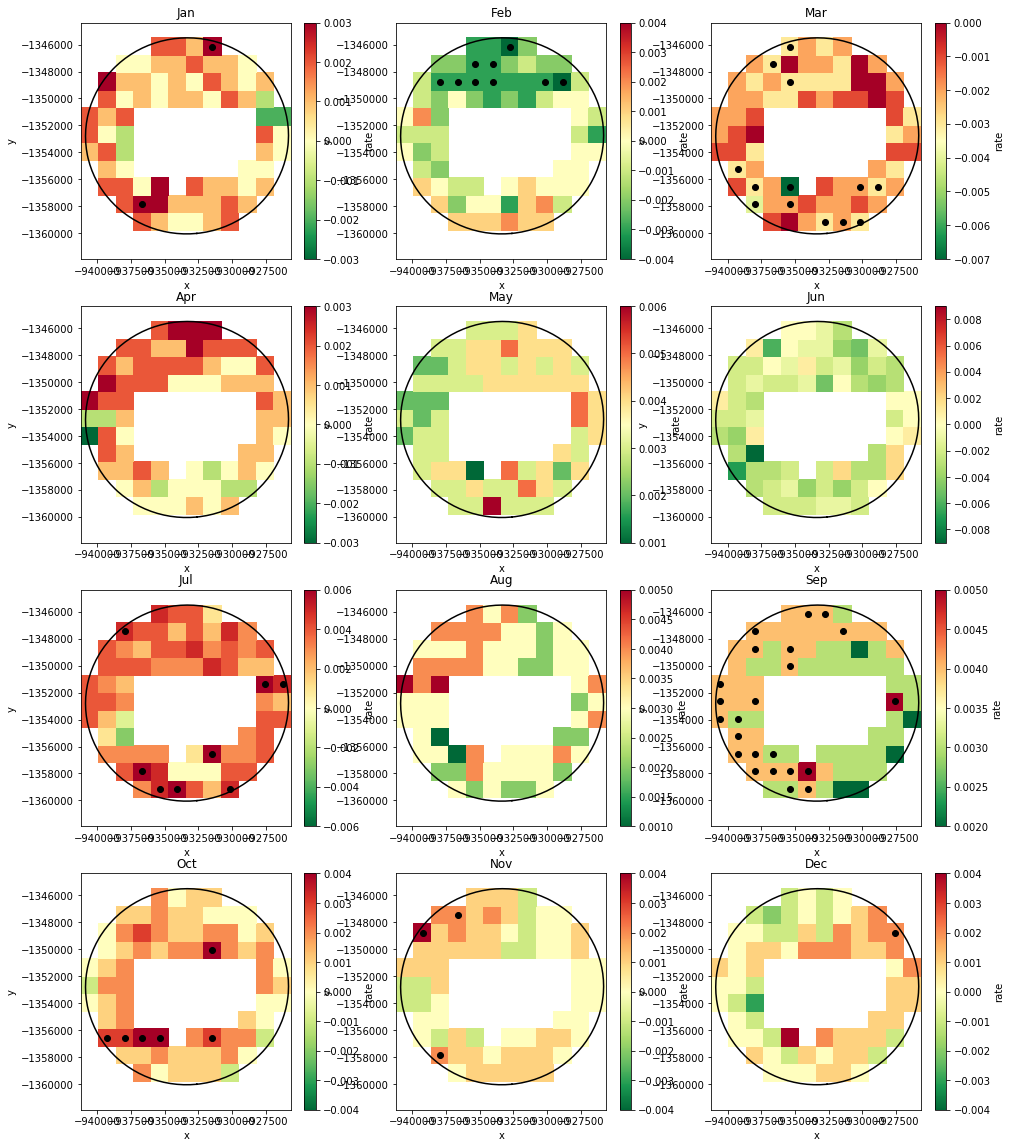

In [109]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)


plt.figure(figsize=(16,20))

plt.subplot(4,3,1)
yearJanRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Jan')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearJanRateDF[yearJanRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,2)
yearFebRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Feb')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearFebRateDF[yearFebRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,3)
yearMarRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Mar')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearMarRateDF[yearMarRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,4)
yearAprRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Apr')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearAprRateDF[yearAprRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,5)
yearMayRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('May')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearMayRateDF[yearMayRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,6)
yearJunRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Jun')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearJunRateDF[yearJunRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,7)
yearJulRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Jul')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearJulRateDF[yearJulRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,8)
yearAugRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Aug')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearAugRateDF[yearAugRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,9)
yearSepRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Sep')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearSepRateDF[yearSepRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,10)
yearOctRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Oct')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearOctRateDF[yearOctRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,11)
yearNovRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Nov')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearNovRateDF[yearNovRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,12)
yearDecRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Dec')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearDecRateDF[yearDecRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


**the same as above, except sharing the X and Y axes**

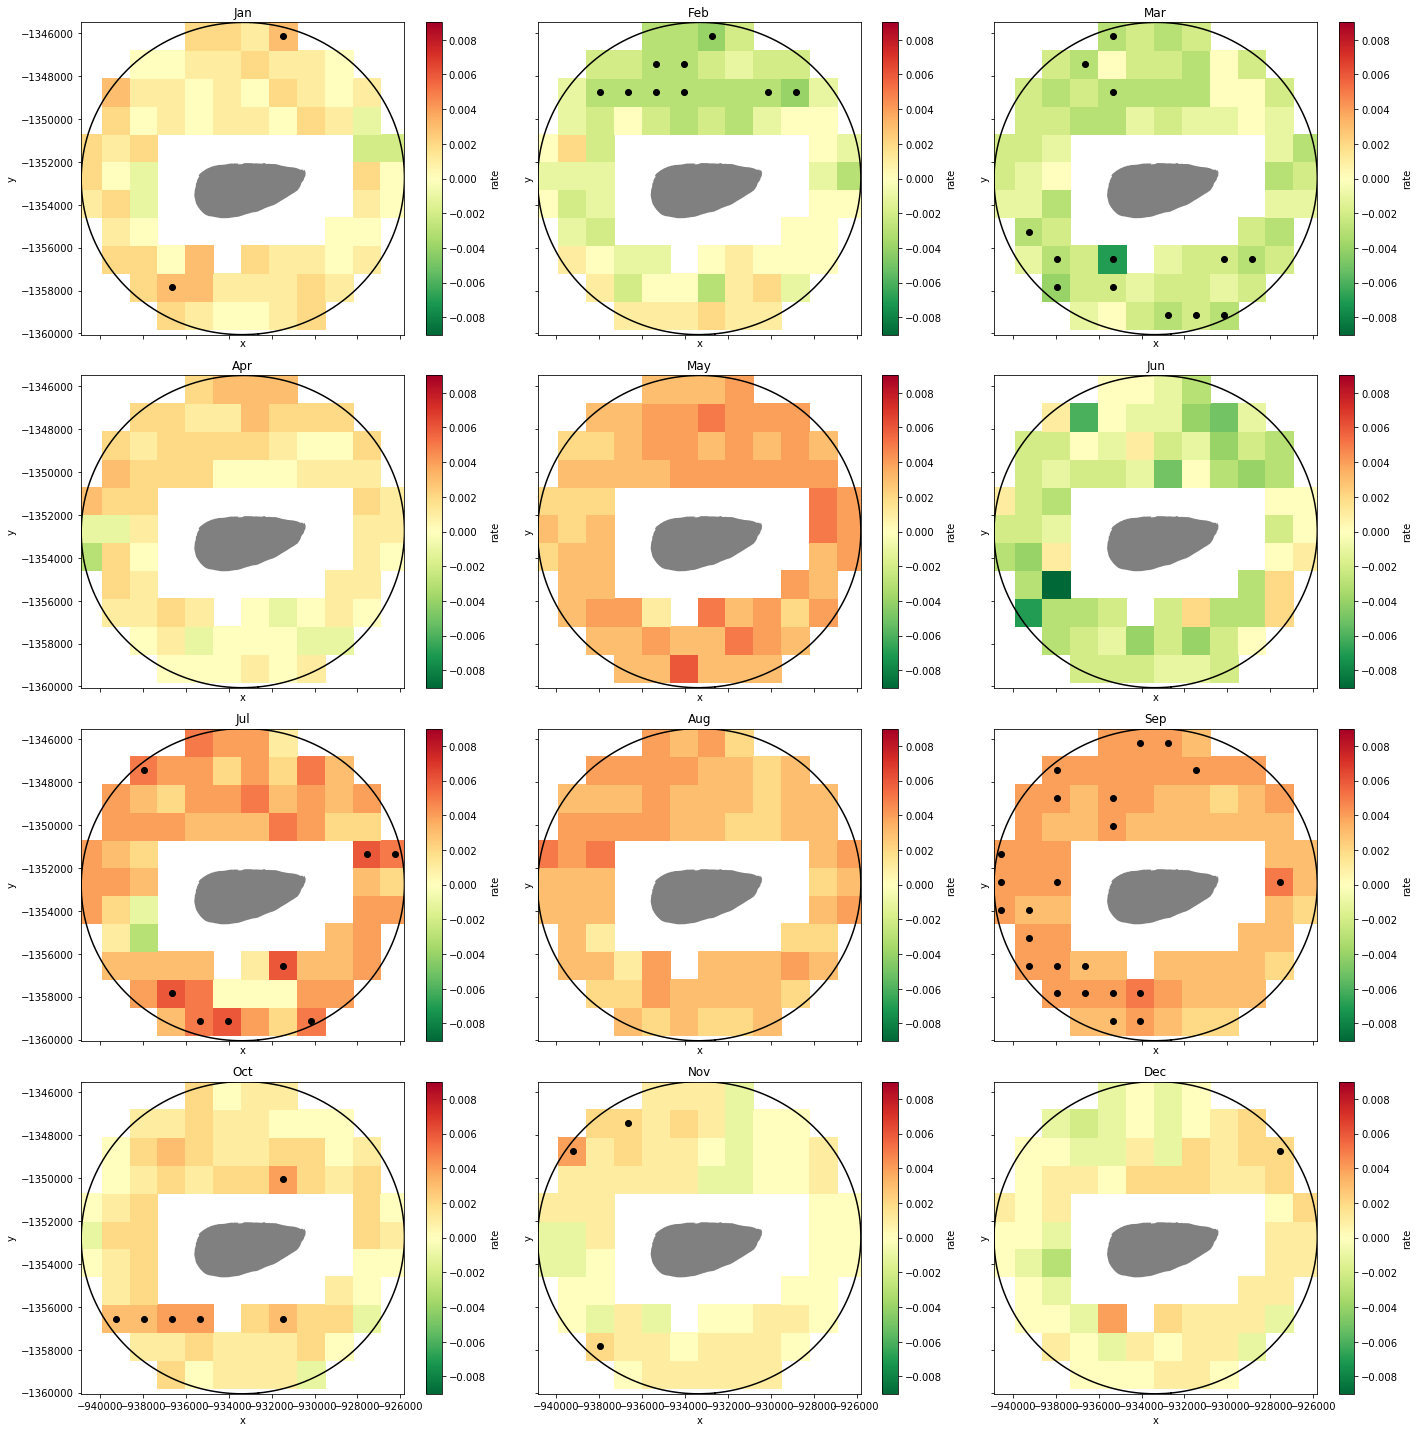

In [110]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

x=[yearJanRateData['rate'].min().values,yearFebRateData['rate'].min().values,
  yearMarRateData['rate'].min().values,yearAprRateData['rate'].min().values,
  yearMayRateData['rate'].min().values,yearJunRateData['rate'].min().values,
  yearJulRateData['rate'].min().values,yearAugRateData['rate'].min().values,
  yearSepRateData['rate'].min().values,yearOctRateData['rate'].min().values,
  yearNovRateData['rate'].min().values,yearDecRateData['rate'].min().values]
minV = min(x)
x=[yearJanRateData['rate'].max().values,yearFebRateData['rate'].max().values,
  yearMarRateData['rate'].max().values,yearAprRateData['rate'].max().values,
  yearMayRateData['rate'].max().values,yearJunRateData['rate'].max().values,
  yearJulRateData['rate'].max().values,yearAugRateData['rate'].max().values,
  yearSepRateData['rate'].max().values,yearOctRateData['rate'].max().values,
  yearNovRateData['rate'].max().values,yearDecRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

    
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(20,20))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])
yearJanRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('Jan')
tempDF = yearJanRateDF[yearJanRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
yearFebRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('Feb')
tempDF = yearFebRateDF[yearFebRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,2])
yearMarRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,2],vmin=minV,vmax=maxV)
axes[0,2].set_title('Mar')
tempDF = yearMarRateDF[yearMarRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
yearAprRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('Apr')
tempDF = yearAprRateDF[yearAprRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
yearMayRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('May')
tempDF = yearMayRateDF[yearMayRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,2])
yearJunRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,2],vmin=minV,vmax=maxV)
axes[1,2].set_title('Jun')
tempDF = yearJunRateDF[yearJunRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,0])
yearJulRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,0],vmin=minV,vmax=maxV)
axes[2,0].set_title('Jul')
tempDF = yearJulRateDF[yearJulRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,1])
yearAugRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,1],vmin=minV,vmax=maxV)
axes[2,1].set_title('Aug')
tempDF = yearAugRateDF[yearAugRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,2])
yearSepRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,2],vmin=minV,vmax=maxV)
axes[2,2].set_title('Sep')
tempDF = yearSepRateDF[yearSepRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,0])
yearOctRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,0],vmin=minV,vmax=maxV)
axes[3,0].set_title('Oct')
tempDF = yearOctRateDF[yearOctRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,1])
yearNovRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,1],vmin=minV,vmax=maxV)
axes[3,1].set_title('Nov')
tempDF = yearNovRateDF[yearNovRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,2])
yearDecRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,2],vmin=minV,vmax=maxV)
axes[3,2].set_title('Dec')
tempDF = yearDecRateDF[yearDecRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

## identify productivity hotspot

**define a function for the identification of productivity hotspot**

In [111]:
def hotspot(statsDF,dataDF):
    ## high productivity threshold is (spatial) mean + 2 * (spatial) std
    # statsDF is a dataframe containing time-series statistics of each cell
    # dataDF is a dataframe containing time-series data for each cell
    a = statsDF['mean'].mean() + 2 * statsDF['mean'].std()
    print(a)
    hotspotDF = pd.DataFrame()
    idList = []
    probList = []
    freqList = []
    for col in dataDF.columns:

        if col.isdigit():
            #print(col)

            nuData = dataDF.index.size - np.isnan(dataDF[col]).sum()
            if nuData > 0:
                idList.append(col)
                # for each cell, calculate the hotspot probability which equals the freqency of high-productivity days out of the total observed days
                prob = (dataDF[col]>a).sum() / nuData 
                probList.append(prob)
                freq = nuData / dataDF.index.size
                freqList.append(freq)
        else:
            break
    hotspotDF['id'] = idList
    hotspotDF['prob'] = probList
    hotspotDF['freq'] = freqList
    hotspotDF.set_index('id',inplace=True)
    xList = []
    yList = []
    for id in hotspotDF.index:
        x = int(latlonDF.loc[id]['lon'])
        y = int(latlonDF.loc[id]['lat'])
        xList.append(x)
        yList.append(y)
    hotspotDF['x'] = xList
    hotspotDF['y'] = yList
    
    return hotspotDF


**identify the overall hotspot**

In [112]:
overallhotspotDF = hotspot(overallDF,chlDF)

0.24478386726454524


In [113]:
overallhotspotDF

prob      freq       x        y
id                                      
17   0.364434  0.348407 -935350 -1346150
18   0.366651  0.349372 -934050 -1346150
19   0.366943  0.349533 -932750 -1346150
20   0.374199  0.351786 -931450 -1346150
27   0.359201  0.346315 -937950 -1347450
..        ...       ...     ...      ...
137  0.311286  0.347924 -935350 -1359150
138  0.327747  0.345671 -934050 -1359150
139  0.324513  0.346637 -932750 -1359150
140  0.320240  0.348246 -931450 -1359150
141  0.318962  0.347119 -930150 -1359150

[74 rows x 4 columns]

In [114]:
import xarray as xr
overallhotspotDF1 = overallhotspotDF.copy()
overallhotspotDF1.set_index(['y','x'],inplace=True)
overallhotspotData = xr.Dataset.from_dataframe(overallhotspotDF1)
overallhotspotData.attrs['crs']='EPSG:3577'
overallhotspotData.to_netcdf(path='/home/547/zxh547/dea-notebooks/overallhotspotData_CHL.nc')

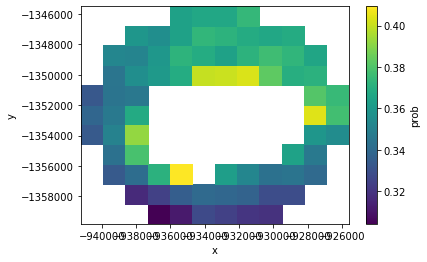

In [115]:
overallhotspotData.prob.plot()

**A hotspot is assessed against the 0.75 threshold value (75% of time with high-productivity)**

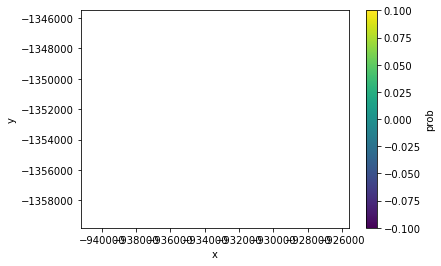

In [116]:
overallhotspotData1 = overallhotspotData.where(overallhotspotData['prob'] >= 0.75)
overallhotspotData1.prob.plot()

**display spatial distribution of overall productivity hotspot; the black dots indicate observation frequency greater than 30%**

<Figure size 720x576 with 0 Axes>

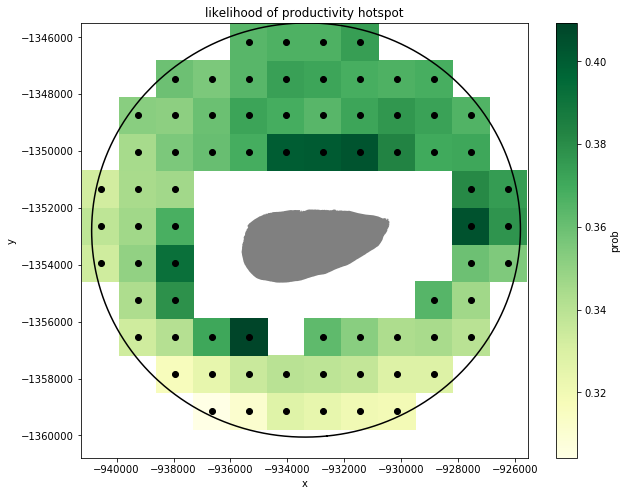

In [117]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

fig = plt.figure(figsize=(10,8))
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',figsize=(10,8))
overallhotspotData['prob'].plot(cmap='YlGn')
plt.title('likelihood of productivity hotspot')
plt.axis('equal')
tempDF = overallhotspotDF[overallhotspotDF['freq'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


**identify seasonal hotspots**

In [118]:
tempDF = chlDF[chlDF['season'] == 'winter']
winterhotspotDF = hotspot(winterCHLDF,tempDF)

tempDF = chlDF[chlDF['season'] == 'spring']
springhotspotDF = hotspot(springCHLDF,tempDF)

tempDF = chlDF[chlDF['season'] == 'summer']
summerhotspotDF = hotspot(summerCHLDF,tempDF)

tempDF = chlDF[chlDF['season'] == 'autumn']
autumnhotspotDF = hotspot(autumnCHLDF,tempDF)

0.3592094203542889
0.15571063881951722
0.12801667640671502
0.20263477207253244


In [119]:
autumnhotspotDF

prob      freq       x        y
id                                      
17   0.314783  0.367647 -935350 -1346150
18   0.325342  0.373402 -934050 -1346150
19   0.328308  0.381714 -932750 -1346150
20   0.366782  0.369565 -931450 -1346150
27   0.309811  0.371483 -937950 -1347450
..        ...       ...     ...      ...
137  0.217241  0.370844 -935350 -1359150
138  0.233677  0.372123 -934050 -1359150
139  0.237847  0.368286 -932750 -1359150
140  0.236615  0.370205 -931450 -1359150
141  0.246454  0.360614 -930150 -1359150

[74 rows x 4 columns]

In [120]:
import xarray as xr
winterhotspotDF1 = winterhotspotDF.copy()
winterhotspotDF1.set_index(['y','x'],inplace=True)
winterhotspotData = xr.Dataset.from_dataframe(winterhotspotDF1)
winterhotspotData.attrs['crs']='EPSG:3577'
winterhotspotData.to_netcdf(path='/home/547/zxh547/dea-notebooks/winterhotspotData_CHL.nc')

In [121]:
import xarray as xr
springhotspotDF1 = springhotspotDF.copy()
springhotspotDF1.set_index(['y','x'],inplace=True)
springhotspotData = xr.Dataset.from_dataframe(springhotspotDF1)
springhotspotData.attrs['crs']='EPSG:3577'
springhotspotData.to_netcdf(path='/home/547/zxh547/dea-notebooks/springhotspotData_CHL.nc')

In [122]:
import xarray as xr
summerhotspotDF1 = summerhotspotDF.copy()
summerhotspotDF1.set_index(['y','x'],inplace=True)
summerhotspotData = xr.Dataset.from_dataframe(summerhotspotDF1)
summerhotspotData.attrs['crs']='EPSG:3577'
summerhotspotData.to_netcdf(path='/home/547/zxh547/dea-notebooks/summerhotspotData_CHL.nc')

In [123]:
import xarray as xr
autumnhotspotDF1 = autumnhotspotDF.copy()
autumnhotspotDF1.set_index(['y','x'],inplace=True)
autumnhotspotData = xr.Dataset.from_dataframe(autumnhotspotDF1)
autumnhotspotData.attrs['crs']='EPSG:3577'
autumnhotspotData.to_netcdf(path='/home/547/zxh547/dea-notebooks/autumnhotspotData_CHL.nc')

In [124]:
autumnhotspotDF

prob      freq       x        y
id                                      
17   0.314783  0.367647 -935350 -1346150
18   0.325342  0.373402 -934050 -1346150
19   0.328308  0.381714 -932750 -1346150
20   0.366782  0.369565 -931450 -1346150
27   0.309811  0.371483 -937950 -1347450
..        ...       ...     ...      ...
137  0.217241  0.370844 -935350 -1359150
138  0.233677  0.372123 -934050 -1359150
139  0.237847  0.368286 -932750 -1359150
140  0.236615  0.370205 -931450 -1359150
141  0.246454  0.360614 -930150 -1359150

[74 rows x 4 columns]

**display spatial distributions of the seasonal hotspots; the black dots indicate the observation frequency greater than 30%**

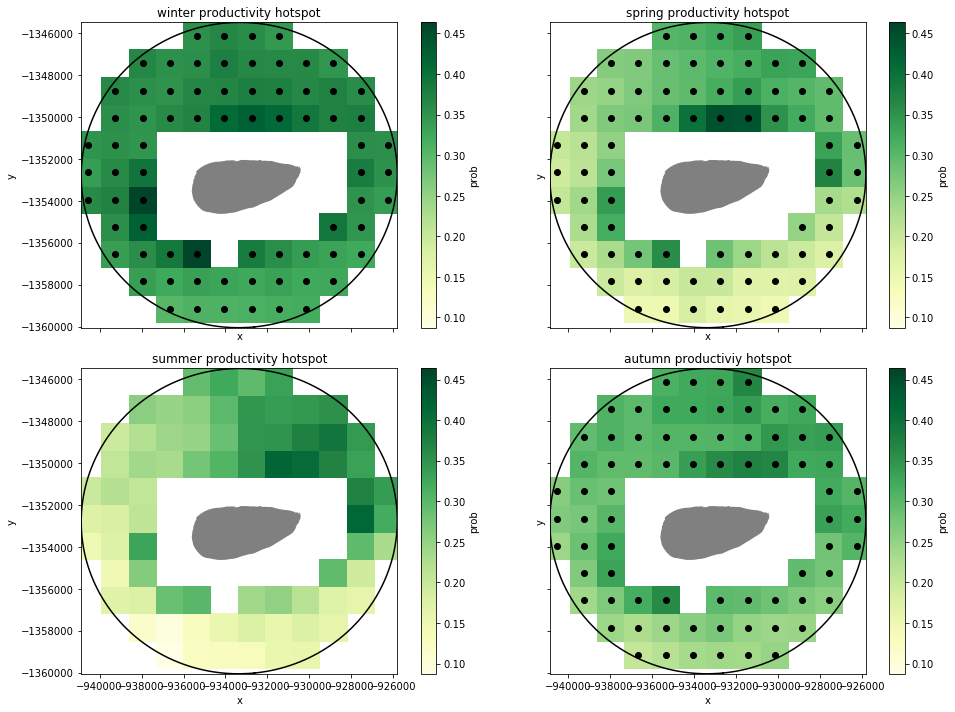

In [160]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

x=[winterhotspotData['prob'].min().values,summerhotspotData['prob'].min().values,
  springhotspotData['prob'].min().values,autumnhotspotData['prob'].min().values]
minV = min(x)
x=[winterhotspotData['prob'].max().values,summerhotspotData['prob'].max().values,
  springhotspotData['prob'].max().values,autumnhotspotData['prob'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])

winterhotspotData['prob'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('winter productivity hotspot')
#axes[0,0].axis('equal')

tempDF = winterhotspotDF[winterhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
springhotspotData['prob'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('spring productivity hotspot')
#axes[0,1].axis('equal')

tempDF = springhotspotDF[springhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
summerhotspotData['prob'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('summer productivity hotspot')
#axes[1,0].axis('equal')

tempDF = summerhotspotDF[summerhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
autumnhotspotData['prob'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('autumn productiviy hotspot')
#axes[1,1].axis('equal')

tempDF = autumnhotspotDF[autumnhotspotDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**identify daily hotspots**

In [126]:
a = overallDF['mean'].mean() + 2 * overallDF['mean'].std()
print(a)
dailyhotspotDF = pd.DataFrame()
hotspotList = []
observedList = []
propList = []
dates = []
for i in chlDF.index:
    dates.append(i)
    hotspot = (chlDF.loc[i]['1':'156'] > a).sum()
    observed = (chlDF.loc[i]['1':'156'] > 0).sum()
    if observed > 0:
        prop = hotspot/observed

    else:
        prop = np.nan
    hotspotList.append(hotspot)
    observedList.append(observed)
    propList.append(prop)
dailyhotspotDF['date'] =dates
dailyhotspotDF['hotspot'] = hotspotList
dailyhotspotDF['observed'] = observedList
dailyhotspotDF['prop'] = propList
dailyhotspotDF.set_index('date',inplace=True)

0.24478386726454524


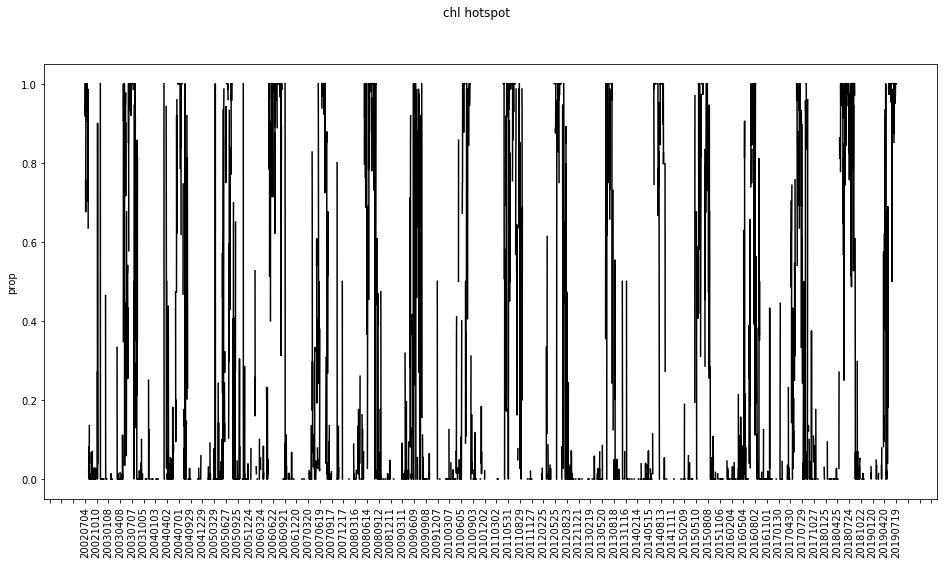

In [127]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(dailyhotspotDF.index.values,dailyhotspotDF['prop'].values,color='black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('prop')
fig.suptitle('chl hotspot')

plt.show()

In [128]:
dailyhotspotDF

hotspot  observed      prop
date                                 
20020704       68        74  0.918919
20020705       74        74  1.000000
20020706       74        74  1.000000
20020707        0         0       NaN
20020708       72        74  0.972973
...           ...       ...       ...
20190718       74        74  1.000000
20190719       74        74  1.000000
20190720        1         1  1.000000
20190721       74        74  1.000000
20190722        0         0       NaN

[6214 rows x 3 columns]

In [129]:
dailyhotspotDF['year'] = chlDF['year']
dailyhotspotDF['season'] = chlDF['season']
dailyhotspotDF['month'] = chlDF['month']

**hotspot time-series of annual statistics (e.g., mean, std, etc)**

In [130]:
x = dailyhotspotDF['prop'].groupby(dailyhotspotDF['year'])

yearHotspotDF = x.describe()

yearHotspotDF1 = yearHotspotDF.loc['2003':'2018']

In [131]:
yearHotspotDF1

count      mean       std  min  25%       50%       75%  max
year                                                              
2003  182.0  0.342843  0.421367  0.0  0.0  0.026014  0.851351  1.0
2004  180.0  0.279343  0.385752  0.0  0.0  0.040541  0.529762  1.0
2005  185.0  0.269982  0.373529  0.0  0.0  0.038462  0.500000  1.0
2006  166.0  0.432309  0.448903  0.0  0.0  0.163333  0.981607  1.0
2007  169.0  0.242891  0.359010  0.0  0.0  0.027027  0.378788  1.0
2008  181.0  0.376434  0.434115  0.0  0.0  0.067568  0.923077  1.0
2009  174.0  0.208227  0.340087  0.0  0.0  0.000000  0.283150  1.0
2010  162.0  0.251854  0.378473  0.0  0.0  0.014925  0.409387  1.0
2011  154.0  0.498830  0.425577  0.0  0.0  0.549754  0.986486  1.0
2012  170.0  0.334073  0.423184  0.0  0.0  0.027799  0.846446  1.0
2013  167.0  0.224899  0.358020  0.0  0.0  0.000000  0.375702  1.0
2014  175.0  0.298507  0.426597  0.0  0.0  0.000000  0.807740  1.0
2015  177.0  0.329956  0.412425  0.0  0.0  0.022222  0.756757  1.0
2016  205.0  0.178415  0.321691  0.0  0.0  0.000000  0.166667  1.0
2017  173.0  0.304341  0.374399  0.0  0.0  0.081633  0.635135  1.0
2018  181.0  0.433514  0.450587  0.0  0.0  0.225806  0.970149  1.0

**plot and fit the hotspot time-series of annual mean**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                 1.427e-05
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.997
Time:                        11:44:34   Log-Likelihood:                 16.594
No. Observations:                  16   AIC:                            -29.19
Df Residuals:                      14   BIC:                            -27.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3127      0.048      6.504      0.0

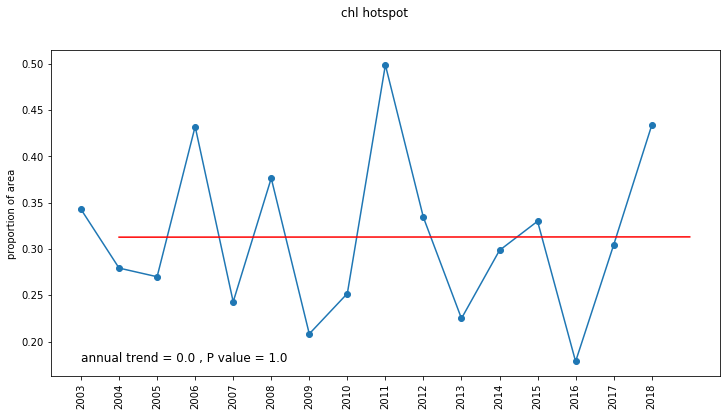

In [161]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearHotspotDF1['mean'].size+1,1)
yearHotspotDF1['ind'] = ind

meanFit = sm.ols(formula='mean ~ ind', data=yearHotspotDF1).fit()
print(meanFit.summary())

predict = meanFit.predict(yearHotspotDF1)
yearHotspotDF1['mean_fitted'] = predict


fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation='vertical')

rate = round(meanFit.params[1],3)
pValue = round(meanFit.pvalues[1],2)


textX = yearHotspotDF1.index[0]
textY = yearHotspotDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearHotspotDF1.index.values,yearHotspotDF1['mean'].values,marker='o')


#ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(yearHotspotDF1.ind, yearHotspotDF1.mean_fitted, 'r')
ax.set_ylabel('proportion of area')
fig.suptitle('chl hotspot')

plt.show()

**hotspot's seasonal statistics**

In [133]:
x = dailyhotspotDF['prop'].groupby(dailyhotspotDF['season'])
seasonHotspotDF = x.describe()

In [134]:
seasonHotspotDF

count      mean       std  min       25%       50%       75%  max
season                                                                    
autumn   800.0  0.192372  0.322957  0.0  0.000000  0.014599  0.213407  1.0
spring   753.0  0.077307  0.209025  0.0  0.000000  0.000000  0.027027  1.0
summer   369.0  0.036462  0.142362  0.0  0.000000  0.000000  0.000000  1.0
winter  1073.0  0.674669  0.377134  0.0  0.344828  0.864865  1.000000  1.0

In [135]:
numDays = []
for season in seasonHotspotDF.index:
    print(season)
    numDay = (dailyhotspotDF['season'] == season).sum()
    numDays.append(numDay)
seasonHotspotDF['numDay'] = numDays
seasonHotspotDF['freq'] = seasonHotspotDF['count'] / seasonHotspotDF['numDay']

autumn
spring
summer
winter


**plot the hotspot's seasonal means and observation frequency**

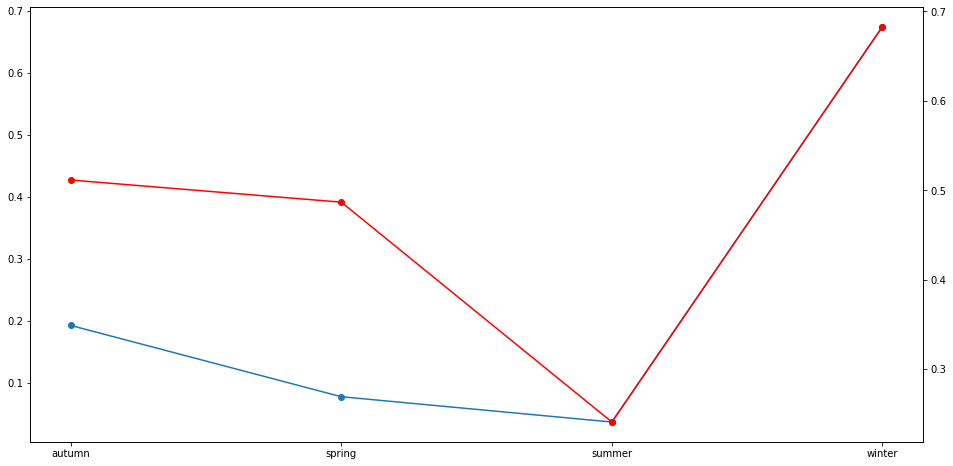

In [136]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(seasonHotspotDF.index,seasonHotspotDF['mean'],marker='o')
ax2.plot(seasonHotspotDF.index,seasonHotspotDF['freq'],color='red',marker='o')

**hotspot's monthly statistics**

In [137]:
x = dailyhotspotDF['prop'].groupby(dailyhotspotDF['month'])
monthHotspotDF = x.describe()

In [138]:
monthHotspotDF

count      mean       std  min       25%       50%       75%  max
month                                                                   
01     105.0  0.041087  0.171597  0.0  0.000000  0.000000  0.000000  1.0
02     140.0  0.042841  0.148977  0.0  0.000000  0.000000  0.000000  1.0
03     196.0  0.058757  0.166922  0.0  0.000000  0.000000  0.027120  1.0
04     287.0  0.107160  0.251823  0.0  0.000000  0.000000  0.040541  1.0
05     317.0  0.352134  0.381919  0.0  0.013514  0.156250  0.735294  1.0
06     339.0  0.693255  0.349346  0.0  0.457002  0.847826  1.000000  1.0
07     364.0  0.841800  0.259707  0.0  0.813636  0.978832  1.000000  1.0
08     370.0  0.493219  0.417343  0.0  0.044697  0.479730  0.985401  1.0
09     315.0  0.130713  0.273038  0.0  0.000000  0.000000  0.068966  1.0
10     230.0  0.048781  0.150671  0.0  0.000000  0.000000  0.013514  1.0
11     208.0  0.027968  0.113292  0.0  0.000000  0.000000  0.000000  1.0
12     124.0  0.025345  0.102314  0.0  0.000000  0.000000  0.000000  0.6

In [139]:
numDays = []
for month in monthHotspotDF.index:
    print(month)
    numDay = (dailyhotspotDF['month'] == month).sum()
    numDays.append(numDay)
monthHotspotDF['numDay'] = numDays
monthHotspotDF['freq'] = monthHotspotDF['count'] / monthHotspotDF['numDay']

01
02
03
04
05
06
07
08
09
10
11
12


**plot hotspot's monthly mean and observation frequency**

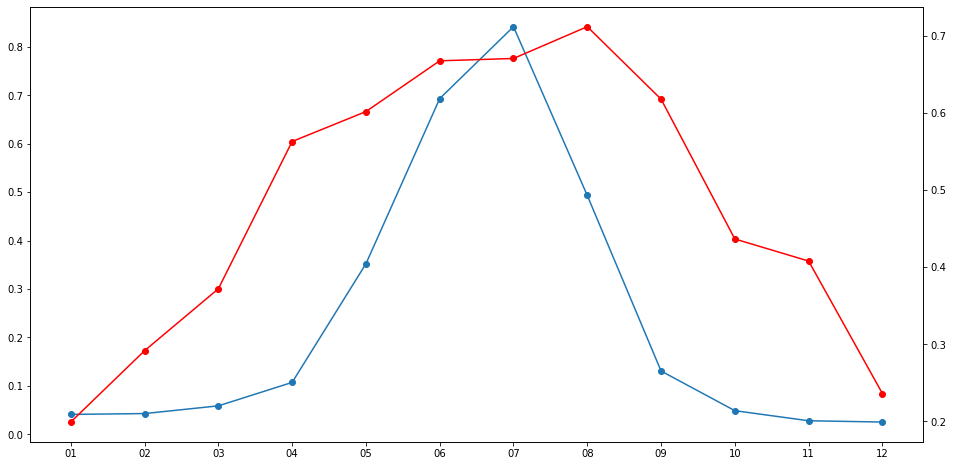

In [140]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(monthHotspotDF.index,monthHotspotDF['mean'],marker='o')
ax2.plot(monthHotspotDF.index,monthHotspotDF['freq'],color='red',marker='o')

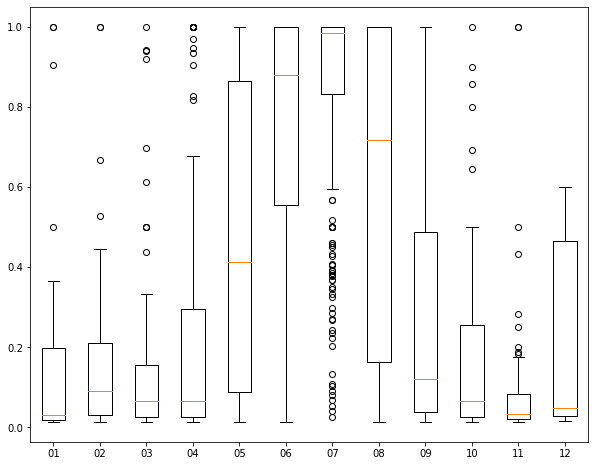

In [141]:
boxplotData = []
monthList = []
months = dailyhotspotDF['month'].unique()
months.sort()
for month in months:
    
    x = dailyhotspotDF[dailyhotspotDF['month'] == month]
    y = x[x['prop']>0]['prop']
    monthList.append(month)

    boxplotData.append(y)

fig = plt.figure(figsize=(10,8))

plt.boxplot(boxplotData,labels=monthList)
plt.show()

In [142]:
dailyhotspotDF.head(10)

hotspot  observed      prop  year  season month
date                                                     
20020704       68        74  0.918919  2002  winter    07
20020705       74        74  1.000000  2002  winter    07
20020706       74        74  1.000000  2002  winter    07
20020707        0         0       NaN  2002  winter    07
20020708       72        74  0.972973  2002  winter    07
20020709        0         0       NaN  2002  winter    07
20020710       56        74  0.756757  2002  winter    07
20020711       50        74  0.675676  2002  winter    07
20020712       66        74  0.891892  2002  winter    07
20020713       73        74  0.986486  2002  winter    07